In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap

/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use DES y1 to get reasonable parameters for the mass-richness relation 

In [2]:
# Path to your FITS file
file_path = '/sps/euclid/Users/cmurray/clusters_likelihood/redmapper_y1a1_public_v6.4_catalog.fits.gz'

# Load the FITS file into an Astropy Table
redmapper_catalogue = Table.read(file_path, format='fits')


redmapper_catalogue.remove_columns( ['P_CEN', 'RA_CEN', 'DEC_CEN', 'ID_CEN', 'PZBINS', 'PZ'] )
redmapper_catalogue = redmapper_catalogue.to_pandas()

In [3]:
redmapper_catalogue

ID                     NAME          RA        DEC  Z_LAMBDA  \
0         1  b'RMJ025415.5-585710.7'   43.564574 -58.952970  0.429804   
1         2  b'RMJ051637.4-543001.6'   79.155704 -54.500456  0.304161   
2         3  b'RMJ041111.0-481939.6'   62.795694 -48.327672  0.419369   
3         4  b'RMJ024524.8-530145.4'   41.353375 -53.029288  0.301129   
4         5  b'RMJ224851.8-443106.3'  342.215897 -44.518403  0.351486   
...     ...                      ...         ...        ...       ...   
6724  33538  b'RMJ000918.5-552738.4'    2.327241 -55.460656  0.535599   
6725  33839  b'RMJ041730.0-542204.2'   64.374976 -54.367826  0.670123   
6726  36361  b'RMJ041818.0-454225.4'   64.574808 -45.707065  0.599167   
6727  40510  b'RMJ011743.4-423414.0'   19.430788 -42.570568  0.550219   
6728  41578  b'RMJ095707.3+021040.4'  149.280213   2.177898  0.827613   

      Z_LAMBDA_ERR      LAMBDA  LAMBDA_ERR         S  Z_SPEC  \
0         0.012092  234.503677    7.524398  1.056760    -1.0   
1         0.007928  195.069565    6.777896  1.054525    -1.0   
2         0.012649  174.460098    5.073172  1.020732    -1.0   
3         0.007855  146.238403    4.044031  1.009022    -1.0   
4         0.010535  178.838272    8.712300  1.175402    -1.0   
...            ...         ...         ...       ...     ...   
6724      0.011719   21.117098    3.857398  1.139642    -1.0   
6725      0.019307   20.949293    3.114584  1.110266    -1.0   
6726      0.015502   21.132353    4.733696  1.269590    -1.0   
6727      0.011026   20.781488    3.890707  1.102398    -1.0   
6728      0.007958   20.247564    4.758243  1.231356    -1.0   

      COADD_OBJECTS_ID  MAG_AUTO_G  MAGERR_AUTO_G  MAG_AUTO_R  MAGERR_AUTO_R  \
0           3089939451   20.175312       0.016915   18.321383       0.008136   
1           3047101906   19.667797       0.006787   17.954527       0.002154   
2           3069562192   19.575390       0.009780   17.845314       0.004595   
3           3092286075   18.861450       0.006732   17.305017       0.003943   
4           3138662814   19.863644       0.008220   18.214876       0.003940   
...                ...         ...            ...         ...            ...   
6724        3125722960   22.477217       0.046772   20.689310       0.016447   
6725        3067653261   23.217733       0.068689   21.364346       0.021354   
6726        3067376486   21.913805       0.055043   20.404688       0.031795   
6727        3114745735   22.120596       0.032472   20.347132       0.013752   
6728        3172662857   23.713654       0.063996   21.740726       0.014301   

      MAG_AUTO_I  MAGERR_AUTO_I  MAG_AUTO_Z  MAGERR_AUTO_Z  ZLUM  
0      17.693726       0.008200   17.325676       0.008411  -1.0  
1      17.444197       0.002180   17.169514       0.002899  -1.0  
2      17.227699       0.004688   16.868717       0.005000  -1.0  
3      16.792620       0.004125   16.469460       0.005136  -1.0  
4      17.675528       0.003998   17.349815       0.005363  -1.0  
...          ...            ...         ...            ...   ...  
6724   19.941771       0.015854   19.563747       0.018995  -1.0  
6725   20.297247       0.018293   19.863497       0.021155  -1.0  
6726   19.339394       0.028830   18.872198       0.029461  -1.0  
6727   19.534012       0.012425   19.149019       0.014458  -1.0  
6728   20.470062       0.012153   19.876162       0.012805  -1.0  

[6729 rows x 20 columns]

In [4]:
redmapper_catalogue['LAMBDA'].min(), redmapper_catalogue['LAMBDA'].max()

(20.003485, 234.50368)

In [5]:
rich_bins = np.logspace( np.log10( 20 ) , np.log10( 240 ) , 50 )
rich_cents = ( rich_bins[1:] + rich_bins[:-1] )/2.

In [6]:
n_clusters , _  = np.histogram( redmapper_catalogue['LAMBDA'], bins = rich_bins )

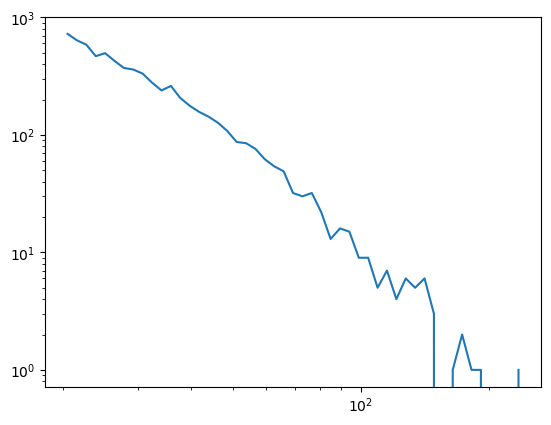

In [7]:
plt.figure()
plt.plot( rich_cents , n_clusters )
plt.xscale('log')
plt.yscale('log')

In [8]:
des_lambda_bins = np.array( [ 20 , 30 , 45 , 60 , 240 ])
# des_lambda_bins = np.array( [ 30 , 45 , 60 , 240 ])
des_z_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])

In [9]:
des_lambda_cent = ( des_lambda_bins[1:] + des_lambda_bins[:-1] )/2.
des_z_cent = ( des_z_bins[1:] + des_z_bins[:-1] )/2.

In [10]:
i = 0 
z_idx_0 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 1 
z_idx_1 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 2 
z_idx_2 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )

In [11]:


des_lambda_bins = np.array( [ 20 , 30 , 45 , 60 , 240 ])
# des_lambda_bins = np.array( [ 30 , 45 , 60 , 240 ])
des_z_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])

i = 0 
z_idx_0 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 1 
z_idx_1 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 2 
z_idx_2 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )

n_clusters_0 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_0 ], bins = des_lambda_bins )
n_clusters_1 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_1 ], bins = des_lambda_bins )
n_clusters_2 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_2 ], bins = des_lambda_bins )

# Mean mass results, Table II DES Y1 cluster abundance results
mwl_mean_0 = np.array( [ 14.036 , 14.323 , 14.454 , 14.758 ] )
mwl_mean_1 = np.array( [ 14.007 , 14.291 , 14.488 , 14.744 ] )
mwl_mean_2 = np.array( [ 13.929 , 14.301 , 14.493 , 14.724 ] )

# mwl_mean_0 = np.array( [ 14.323 , 14.454 , 14.758 ] )
# mwl_mean_1 = np.array( [ 14.291 , 14.488 , 14.744 ] )
# mwl_mean_2 = np.array( [ 14.301 , 14.493 , 14.724 ] )

# Std for aMean mass results, Table II DES Y1 cluster abundance results
mwl_std_0 = np.array( [ 0.032 + 0.045 , 0.031 + 0.051 , 0.044 + 0.050 , 0.038 + 0.052 ] )
mwl_std_1 = np.array( [ 0.033 + 0.056 , 0.031 + 0.061 , 0.044 + 0.065 , 0.038 + 0.052 ] )
mwl_std_2 = np.array( [ 0.048 + 0.072 , 0.041 + 0.086 , 0.056 + 0.068 , 0.061 + 0.069 ] )

# mwl_std_0 = np.array( [ 0.031 + 0.051 , 0.044 + 0.050 , 0.038 + 0.052 ] )
# mwl_std_1 = np.array( [ 0.031 + 0.061 , 0.044 + 0.065 , 0.038 + 0.052 ] )
# mwl_std_2 = np.array( [ 0.041 + 0.086 , 0.056 + 0.068 , 0.061 + 0.069 ] )

(13.7, 15.0)

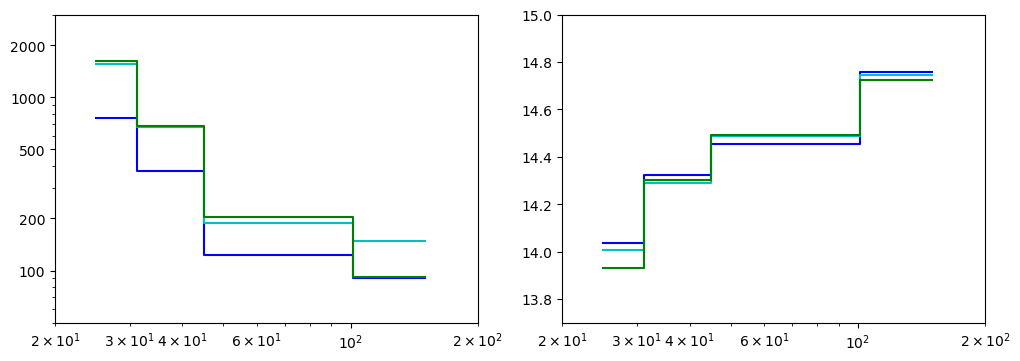

In [12]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( des_lambda_cent , n_clusters_0 , 'b-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_1 , 'c-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_2 , 'g-' , drawstyle = 'steps-mid')
plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 50 , 3000 )

plt.subplot(122)
plt.plot( des_lambda_cent , mwl_mean_0 , 'b-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_1 , 'c-' , drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_2 , 'g-' , drawstyle = 'steps-mid')
plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )

In [13]:
mwl_std = np.array( [ mwl_std_0, mwl_std_1, mwl_std_2 ] ).T

In [41]:
stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
                                                    variable_params=['omega_m', 
                                                                     'sigma_8', 
                                                                     'alpha' , 
                                                                     'c' , 
                                                                     'sigma' ],
                                                    fixed_params={'w_0': -1, 'w_a': 0 , 'beta':0} )

# stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
#                                                     variable_params=['omega_m', 
#                                                                      'sigma_8', 
#                                                                      'alpha' , 
#                                                                      'M1' ,
#                                                                      'Mmin',
#                                                                      'sigma' ],
#                                                     fixed_params={'w_0': -1, 'w_a': 0 , 'beta':0} )
stacked_simulator.selection_richness = 0
stacked_simulator.dOmega = 1500/41253 * 4*np.pi
stacked_simulator.richness_bins = des_lambda_bins
stacked_simulator.redshift_bins = des_z_bins
stacked_simulator.sigma_mwl = 0.3
#stacked_simulator.dlog10m = 0.01
#stacked_simulator.log10ms = np.arange( 13.1, 15.5, stacked_simulator.dlog10m)
stacked_simulator.include_mwl_measurement_errors = True
stacked_simulator.mwl_std = mwl_std
stacked_simulator.correlation_mass_evolution = False
stacked_simulator.cme_mu_bins = np.linspace( np.log( 1e13/1e14 ) , np.log( 10**15.5 /1e14 ), 6  )

stacked_simulator.set_richness_mass_relation( 'power law' )
# stacked_simulator.hmf = ccl.hmf.MassFunc
# stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
#                                                     variable_params=['omega_m', 'sigma_8'],
#                                                     fixed_params={'w_0': -1, 'w_a': 0} )

In [42]:
# make sure that this is the correct size
prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 10 , 10 , 0.05 ] , 
                          high = [ 1.0 , 1.5 , 14 , 14 , 0.5  ] )

In [43]:
stacked_simulator.set_bins( z_bins = np.arange( 0.15 , 0.7 , 0.05 ) , log10m_bins=  np.arange( 12.8, 16, 0.01))

In [44]:
1500/41253

0.03636099192785979

In [45]:
# no_r_stacked_simulator = simulation.Universe_simulation( 'stacked_counts' ,
#                                                     variable_params=['omega_m', 'sigma_8', 'alpha' , 'c' , 'sigma' ],
#                                                     fixed_params={'w_0': -1, 'w_a': 0 , 'r':0} )

# no_r_stacked_simulator.dOmega = 1500/41253 * 4*np.pi
# no_r_stacked_simulator.richness_bins = des_lambda_bins
# no_r_stacked_simulator.redshift_bins = des_z_bins
# no_r_stacked_simulator.z_bins = np.arange( 0.15 , 0.7 , 0.05 )
# no_r_stacked_simulator.sigma_mwl = 0.3
# no_r_stacked_simulator.log10ms = np.arange(13.1, 15.5, stacked_simulator.dlog10m)
# no_r_stacked_simulator.include_mwl_measurement_errors = True
# no_r_stacked_simulator.mwl_std = mwl_std
# no_r_stacked_simulator.correlation_mass_evolution = False


In [46]:
stacked_simulator.available_params

{'omega_m': 0.3,
 'sigma_8': 0.8,
 'h': 0.7,
 'w_0': -1,
 'w_a': 0,
 'alpha': 0.8,
 'c': 3,
 'sigma': 0.3,
 'r': 0.0,
 'beta': 0,
 'c_rho': 0.0,
 'B': 0,
 'log10Mmin': 0}

In [47]:
[0.1505880206823349,
 0.8029483258724213,
 0.6270101070404053,
 3.047786235809326,
 0.2592751234769821,
 0.3899948000907898]

[0.1505880206823349,
 0.8029483258724213,
 0.6270101070404053,
 3.047786235809326,
 0.2592751234769821,
 0.3899948000907898]

In [48]:
float(56.45234234234234)

56.45234234234234

In [49]:
#stacked_simulator.richness_mass_relation = 'power-law'

In [50]:
def halo_model( mu , z , alpha_l, sigma_l, beta_l, B , log10Mmin ):
    Mmin = 10**log10Mmin
    M1 = 10**( B ) * Mmin
    M = ( np.exp( mu ) * 1e14 )
    mean_l = ( ( M - Mmin ) / ( M1 -  Mmin ) )**alpha_l * ( ( 1 + z ) / ( 1 + 1 ) )**beta_l
    mean_l[np.logical_or(mean_l < 0, np.isnan(mean_l))] = 0
    return np.log( np.random.poisson( lam = mean_l ) + 1 )

In [51]:
np.max( np.random.poisson( 0 , size = 100000) )

0

In [52]:
halo_model( [ np.log( 1e13 /1e14 ) , np.log( 2e14 /1e14 )  ], 0.5 , 1/1.3 , 0.3 , 0 , np.log( 10 ) , 13.96440315246582 )

/tmp/ipykernel_1197/3813414263.py:5: RuntimeWarning: invalid value encountered in power
  mean_l = ( ( M - Mmin ) / ( M1 -  Mmin ) )**alpha_l * ( ( 1 + z ) / ( 1 + 1 ) )**beta_l


array([0., 0.])

In [53]:
halo_model( np.log( 5e13 /1e14 ) , 0.5 , 1/1.3 , 0.3 , 0 , np.log( 30 ) , 11.13 )

TypeError: 'numpy.float64' object does not support item assignment

In [60]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.15 , 0.8 , 0.62 , 3.04 , 0.25 , 0.1 , 0 ] )  )
# sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.2 , 0.85 , 1/1.3 , 12.37 , 11.1 , 0.3  ] )  )

/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )


In [61]:
sim_n_clusters = sim_obs[:12].reshape( 4 , 3 )
sim_mwl_mean = sim_obs[12:].reshape( 4 , 3 )

# sim_n_clusters = sim_obs[:9].reshape( 3 , 3 )
# sim_mwl_mean = sim_obs[9:].reshape( 3 , 3 )

sim_n_clusters_0 = sim_n_clusters.T[0]
sim_n_clusters_1 = sim_n_clusters.T[1]
sim_n_clusters_2 = sim_n_clusters.T[2]

sim_mwl_mean_0 = sim_mwl_mean.T[0]
sim_mwl_mean_1 = sim_mwl_mean.T[1]
sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [62]:
sim_n_clusters_0

array([1342.,  423.,  117.,   67.])

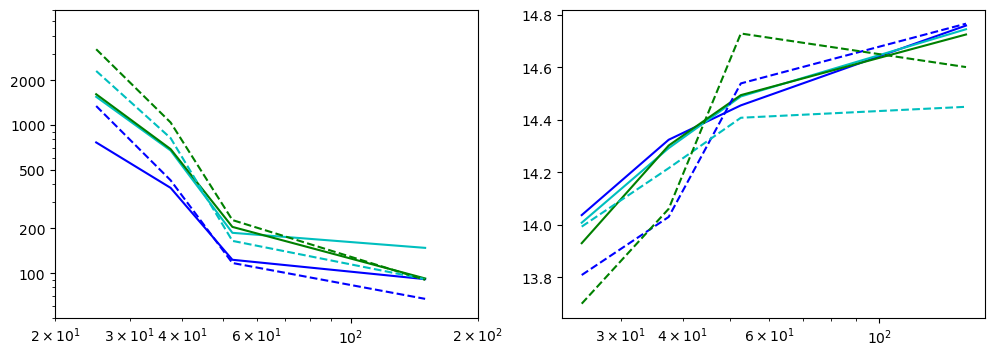

In [63]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( des_lambda_cent , n_clusters_0 , 'b-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_1 , 'c-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , n_clusters_2 , 'g-' ) #, drawstyle = 'steps-mid')

plt.plot( des_lambda_cent , sim_n_clusters_0 , 'b--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_n_clusters_1 , 'c--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_n_clusters_2 , 'g--' ) #, drawstyle = 'steps-mid')

# plt.plot( des_lambda_cent , old_sim_n_clusters_0 , 'b:' ) #, drawstyle = 'steps-mid')
# plt.plot( des_lambda_cent , old_sim_n_clusters_1 , 'c:' ) #, drawstyle = 'steps-mid')
# plt.plot( des_lambda_cent , old_sim_n_clusters_2 , 'g:' ) #, drawstyle = 'steps-mid')
plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 50 , 6000 )

plt.subplot(122)
plt.plot( des_lambda_cent , mwl_mean_0 , 'b-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_1 , 'c-' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , mwl_mean_2 , 'g-' ) #, drawstyle = 'steps-mid')

plt.plot( des_lambda_cent , sim_mwl_mean_0 , 'b--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_mwl_mean_1 , 'c--' ) #, drawstyle = 'steps-mid')
plt.plot( des_lambda_cent , sim_mwl_mean_2 , 'g--' ) #, drawstyle = 'steps-mid')

# plt.plot( des_lambda_cent , old_sim_mwl_mean_0 , 'b:' ) #, drawstyle = 'steps-mid')
# plt.plot( des_lambda_cent , old_sim_mwl_mean_1 , 'c:' ) #, drawstyle = 'steps-mid')
# plt.plot( des_lambda_cent , old_sim_mwl_mean_2 , 'g:' ) #, drawstyle = 'steps-mid')
plt.xscale('log')
# plt.xlim( 20 , 200 )
# plt.ylim( 13.7 , 15 )

In [64]:
# mean_params = [0.5647695064544678,
#  0.7186958491802216,
#  1.8720948100090027,
#  1.8384299874305725,
#  0.4349806308746338]

In [65]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [0.17871107906103134,
                                                         0.693568229675293,
                                                         0.967983686923981,
                                                         3.040264844894409,
                                                          0.24637287110090256,
                                                         0.3546264320611954 , 0 ] )  )

/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )


In [66]:
sim_n_clusters = sim_obs[:12].reshape( 4 , 3 )
sim_mwl_mean = sim_obs[12:].reshape( 4 , 3 )

# sim_n_clusters = sim_obs[:9].reshape( 3 , 3 )
# sim_mwl_mean = sim_obs[9:].reshape( 3 , 3 )

sim_n_clusters_0 = sim_n_clusters.T[0]
sim_n_clusters_1 = sim_n_clusters.T[1]
sim_n_clusters_2 = sim_n_clusters.T[2]

sim_mwl_mean_0 = sim_mwl_mean.T[0]
sim_mwl_mean_1 = sim_mwl_mean.T[1]
sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [67]:
# Assuming the arrays are already of the same shape and are 2D
n_clusters = np.array( [ n_clusters_0, n_clusters_1, n_clusters_2 ]).T
mwl_mean = np.array( [ mwl_mean_0, mwl_mean_1, mwl_mean_2 ] ).T

# Flatten both stacks and concatenate them to match the format of the `stacked_counts` result
des_stacked_results = np.vstack( np.array( [ n_clusters, mwl_mean ] ) ).flatten()  

In [68]:
sim_n_clusters = des_stacked_results[:12].reshape( 4 , 3 )
sim_mwl_mean = des_stacked_results[12:].reshape( 4 , 3 )

# sim_n_clusters = des_stacked_results[:9].reshape( 3 , 3 )
# sim_mwl_mean = des_stacked_results[9:].reshape( 3 , 3 )

alt_sim_n_clusters_0 = sim_n_clusters.T[0]
alt_sim_n_clusters_1 = sim_n_clusters.T[1]
alt_sim_n_clusters_2 = sim_n_clusters.T[2]

alt_sim_mwl_mean_0 = sim_mwl_mean.T[0]
alt_sim_mwl_mean_1 = sim_mwl_mean.T[1]
alt_sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [69]:
[0.17871107906103134,
 0.693568229675293,
 0.5567983686923981,
 3.040264844894409,
 0.24637287110090256,
 0.3546264320611954]

[0.17871107906103134,
 0.693568229675293,
 0.5567983686923981,
 3.040264844894409,
 0.24637287110090256,
 0.3546264320611954]

In [70]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.187871107906103134,
                                                            0.753568229675293,
                                                            1/1.3,
                                                            3.040264844894409,
                                                            0.14637287110090256,
                                                            0.0 , 0 ] )  )

In [71]:
# sim_obs = stacked_simulator.run_simulation( torch.Tensor( mean_params )  )

In [72]:
1/1.3

0.7692307692307692

In [74]:
# Number of simulations to run
n_simulations = 10

# Collect results
sim_n_clusters_0_list = []
sim_n_clusters_1_list = []
sim_n_clusters_2_list = []

sim_mwl_mean_0_list = []
sim_mwl_mean_1_list = []
sim_mwl_mean_2_list = []

# Run multiple simulations and collect the outputs
for _ in range(n_simulations):
    sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.15 , 0.85 , 0.62 , 3.04 , 0.25 , 0. , 0  ] ))

    sim_n_clusters = sim_obs[:12].reshape(4, 3)
    sim_mwl_mean = sim_obs[12:].reshape(4, 3)
    
    # sim_n_clusters = sim_obs[:9].reshape(3, 3)
    # sim_mwl_mean = sim_obs[9:].reshape(3, 3)

    # Extract values
    sim_n_clusters_0_list.append(sim_n_clusters.T[0])
    sim_n_clusters_1_list.append(sim_n_clusters.T[1])
    sim_n_clusters_2_list.append(sim_n_clusters.T[2])

    sim_mwl_mean_0_list.append(sim_mwl_mean.T[0])
    sim_mwl_mean_1_list.append(sim_mwl_mean.T[1])
    sim_mwl_mean_2_list.append(sim_mwl_mean.T[2])

# Convert lists to numpy arrays
sim_n_clusters_0_array = np.array(sim_n_clusters_0_list)
sim_n_clusters_1_array = np.array(sim_n_clusters_1_list)
sim_n_clusters_2_array = np.array(sim_n_clusters_2_list)

sim_mwl_mean_0_array = np.array(sim_mwl_mean_0_list)
sim_mwl_mean_1_array = np.array(sim_mwl_mean_1_list)
sim_mwl_mean_2_array = np.array(sim_mwl_mean_2_list)

# Compute standard deviations
std_n_clusters_0 = np.std(sim_n_clusters_0_array, axis=0)
std_n_clusters_1 = np.std(sim_n_clusters_1_array, axis=0)
std_n_clusters_2 = np.std(sim_n_clusters_2_array, axis=0)

std_mwl_mean_0 = np.std(sim_mwl_mean_0_array, axis=0)
std_mwl_mean_1 = np.std(sim_mwl_mean_1_array, axis=0)
std_mwl_mean_2 = np.std(sim_mwl_mean_2_array, axis=0)

# Print results
print("Standard Deviations for n_clusters_0:", std_n_clusters_0 )
print("Standard Deviations for n_clusters_1:", std_n_clusters_1 )
print("Standard Deviations for n_clusters_2:", std_n_clusters_2 )

Standard Deviations for n_clusters_0: [36.2623772  19.61861361 11.98499061  8.22253002]
Standard Deviations for n_clusters_1: [54.07365347 41.74314315 15.02131818  9.49947367]
Standard Deviations for n_clusters_2: [62.28009313 28.26464222 13.9645981  10.57402478]


In [75]:
print("Standard Deviations for mwl_mean_clusters_0:", std_mwl_mean_0)
print("Standard Deviations for mwl_mean_clusters_1:", std_mwl_mean_1)
print("Standard Deviations for mwl_mean_clusters_2:", std_mwl_mean_2)

Standard Deviations for mwl_mean_clusters_0: [0.09578665 0.09901101 0.07102506 0.08852897]
Standard Deviations for mwl_mean_clusters_1: [0.09663237 0.06429809 0.06977204 0.11162596]
Standard Deviations for mwl_mean_clusters_2: [0.11813135 0.06847085 0.10774144 0.13561065]


In [76]:
mwl_std.T

array([[0.077, 0.082, 0.094, 0.09 ],
       [0.089, 0.092, 0.109, 0.09 ],
       [0.12 , 0.127, 0.124, 0.13 ]])

In [77]:
sim_n_clusters_0_mean = np.mean( sim_n_clusters_0_array , axis = 0 )
sim_n_clusters_1_mean = np.mean( sim_n_clusters_1_array , axis = 0 )
sim_n_clusters_2_mean = np.mean( sim_n_clusters_2_array , axis = 0 )

sim_mwl_mean_0_mean = np.mean( sim_mwl_mean_0_array , axis = 0 )
sim_mwl_mean_1_mean = np.mean( sim_mwl_mean_1_array , axis = 0 )
sim_mwl_mean_2_mean = np.mean( sim_mwl_mean_2_array , axis = 0 )

In [78]:
# chi2 
chi2 = np.sum( ( ( n_clusters_0 - sim_n_clusters_0_mean ) / std_n_clusters_0 )**2 + 
        ( ( n_clusters_1 - sim_n_clusters_1_mean ) / std_n_clusters_1 )**2 +
        ( ( n_clusters_2 - sim_n_clusters_2_mean ) / std_n_clusters_2 )**2 + 
        ( ( mwl_mean_0 - sim_mwl_mean_0_mean ) / std_mwl_mean_0 )**2 +
        ( ( mwl_mean_1 - sim_mwl_mean_1_mean ) / std_mwl_mean_1 )**2 +
        ( ( mwl_mean_2 - sim_mwl_mean_2_mean ) / std_mwl_mean_2 )**2 ) 
chi2

3201.901631810503

In [79]:
chi2 / ( 4 * 3 * 2 - 4 )

160.09508159052515

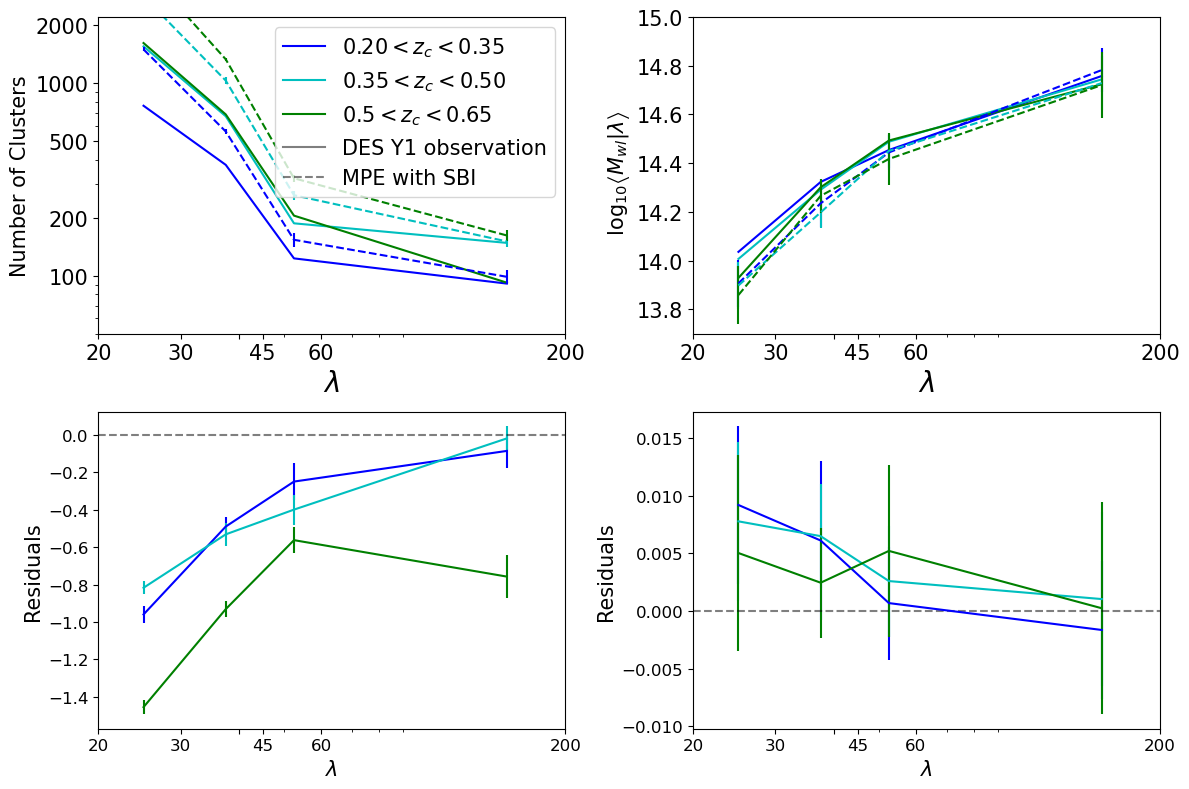

In [80]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Subplot 1: Number of clusters
plt.subplot(221)
plt.plot(des_lambda_cent, n_clusters_0, 'b-', label='$ 0.20 < z_c < 0.35 $')
plt.plot(des_lambda_cent, n_clusters_1, 'c-', label='$ 0.35 < z_c < 0.50 $')
plt.plot(des_lambda_cent, n_clusters_2, 'g-', label='$ 0.5 < z_c < 0.65$')

plt.errorbar(des_lambda_cent, sim_n_clusters_0_mean, fmt='b--' , yerr=std_n_clusters_0 )
plt.errorbar(des_lambda_cent, sim_n_clusters_1_mean, fmt='c--' , yerr=std_n_clusters_1 )
plt.errorbar(des_lambda_cent, sim_n_clusters_2_mean, fmt='g--' , yerr=std_n_clusters_2 )

plt.plot( 0 , 0 , 'k-', alpha = 0.5 , label ='DES Y1 observation')
plt.plot( 0 , 0 , 'k--', alpha = 0.5 , label ='MPE with SBI')

plt.xscale('log')
plt.yscale('log')
plt.yticks([100, 200, 500, 1000, 2000], labels=[100, 200, 500, 1000, 2000])
plt.xlim(20, 200)
plt.ylim(50, 2200)
plt.xlabel(r'$\lambda$' , fontsize = 20)
plt.ylabel('Number of Clusters' , fontsize = 15)
plt.legend(loc='upper right' , fontsize = 15 )
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 15 )
plt.yticks( fontsize = 15 )

# Subplot 2: Mean MWL
plt.subplot(222)
plt.plot(des_lambda_cent, mwl_mean_0, 'b-' )
plt.plot(des_lambda_cent, mwl_mean_1, 'c-' )
plt.plot(des_lambda_cent, mwl_mean_2, 'g-' )

plt.errorbar(des_lambda_cent, sim_mwl_mean_0_mean, fmt='b--' , yerr=std_mwl_mean_0 )
plt.errorbar(des_lambda_cent, sim_mwl_mean_1_mean, fmt='c--' , yerr=std_mwl_mean_1 )
plt.errorbar(des_lambda_cent, sim_mwl_mean_2_mean, fmt='g--' , yerr=std_mwl_mean_2 )

plt.xscale('log')
plt.xlim(20, 200)
plt.ylim(13.7, 15)
plt.xlabel(r'$\lambda$' , fontsize = 20)
plt.ylabel(r' log$_{10} \left< M_{wl} | \lambda \right>$' , fontsize = 15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 15 )
plt.yticks( fontsize = 15 )

# Subplot 3: Residuals for number of clusters
plt.subplot(223)
residual_clusters_0 = n_clusters_0 - sim_n_clusters_0_mean
residual_clusters_1 = n_clusters_1 - sim_n_clusters_1_mean
residual_clusters_2 = n_clusters_2 - sim_n_clusters_2_mean

plt.errorbar(des_lambda_cent, residual_clusters_0 / n_clusters_0 , yerr=std_n_clusters_0 / n_clusters_0, fmt='b-', label='$ 0.20 < z_c < 0.35 $ Residuals')
plt.errorbar(des_lambda_cent, residual_clusters_1 / n_clusters_1 , yerr=std_n_clusters_1 / n_clusters_1, fmt='c-', label='$ 0.35 < z_c < 0.50 $ Residuals')
plt.errorbar(des_lambda_cent, residual_clusters_2 / n_clusters_2 , yerr=std_n_clusters_2 / n_clusters_2, fmt='g-', label='$ 0.5 < z_c < 0.65 $ Residuals')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Subplot 4: Residuals for MWL
plt.subplot(224)
residual_mwl_0 = mwl_mean_0 - sim_mwl_mean_0_mean
residual_mwl_1 = mwl_mean_1 - sim_mwl_mean_1_mean
residual_mwl_2 = mwl_mean_2 - sim_mwl_mean_2_mean

plt.errorbar( des_lambda_cent, 
              residual_mwl_0 / mwl_mean_0, 
              yerr=std_mwl_mean_0 / mwl_mean_0 , fmt='b-', label='$ 0.20 < z_c < 0.35 $ Residuals')
plt.errorbar( des_lambda_cent, 
              residual_mwl_1 / mwl_mean_1, 
              yerr=std_mwl_mean_1 / mwl_mean_1 , fmt='c-', label='$ 0.35 < z_c < 0.50 $ Residuals')
plt.errorbar( des_lambda_cent, 
              residual_mwl_2 / mwl_mean_2, 
              yerr=std_mwl_mean_2 / mwl_mean_2 , fmt='g-', label='$ 0.5 < z_c < 0.65 $ Residuals')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig('temp.png')

Should be able to turn this around to see DES Y1 Figure 8. 

- run a simulation
- look at P(detection) as a function of mass
- loom at sigma( lambda( M) )

In [81]:
# Om0, sigma8, w0 , wa, alpha_l , c_l , sigma_l, r, beta, c_rho

In [82]:
stacked_simulator.selection_richness = 0

In [83]:
stacked_simulator.dOmega

0.45692570047120834

In [84]:
stacked_simulator.dOmega = 4*np.pi 

stacked_simulator.set_bins( z_bins = np.arange( 0.15 , 0.7 , 0.05 ) , log10m_bins=  np.arange( 12.4, 16, 0.01))

full_parameter_set = stacked_simulator._get_parameter_set( torch.Tensor( [ 0.2 , 0.85 , 1/1.3 , 12.37 , 11.1 , 0.3  ] ) )
sim_richness, sim_log10M_wl, sim_z_clusters, sim_mu_clusters = stacked_simulator._run_simulation( full_parameter_set )

stacked_simulator.set_bins( z_bins = np.arange( 0.15 , 0.7 , 0.05 ) , log10m_bins=  np.arange( 12.8, 16, 0.01))

stacked_simulator.dOmega = 0.45692570047120834

In [85]:
full_parameter_set

[0.20000000298023224,
 0.8500000238418579,
 0.7,
 -1,
 0,
 0.7692307829856873,
 12.369999885559082,
 11.100000381469727,
 0.0,
 0,
 0.0,
 0,
 0]

In [86]:
np.min( redmapper_catalogue['Z_LAMBDA']), np.max( redmapper_catalogue['Z_LAMBDA']) , np.min( redmapper_catalogue['LAMBDA']), np.max( redmapper_catalogue['LAMBDA'])

(0.20000643, 0.85766494, 20.003485, 234.50368)

In [87]:
np.min( sim_richness ), np.max( sim_richness )

(2.353253991402588e-23, 1.618297284227736e+33)

In [88]:
len( sim_richness ), len( sim_richness[ ( sim_richness > 20 ) & ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ])

(33233416, 24108823)

In [89]:
log10_m200_bins = np.linspace( 13 , 15.2 , 50 )
log10_m200_cents = ( log10_m200_bins[1:] + log10_m200_bins[:-1] )/2.

In [90]:
log10_m_true_all_no_z = np.log10( np.exp( sim_mu_clusters) * 1e14 )

In [91]:
log10_m_true_sel = np.log10( np.exp( sim_mu_clusters[ ( sim_richness > 20 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) ] ) * 1e14 )
log10_m_true_all = np.log10( np.exp( sim_mu_clusters[ ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) ] ) * 1e14 )

In [92]:
mean_rich , _ , _ = stats.binned_statistic( log10_m_true_all ,  
                                           sim_richness[ ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ]  , 
                                           statistic = np.mean,
                                           bins = log10_m200_bins )


In [93]:
var_rich , _ , _ = stats.binned_statistic( log10_m_true_all ,  
                                           sim_richness[ ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ]  , 
                                           statistic = np.var,
                                           bins = log10_m200_bins )

# count_rich , _ , _ = stats.binned_statistic( log10_m_true_sel ,  
#                                            sim_richness[ ( sim_z_clusters > 0.2 ) * ( sim_z_clusters < 0.857 ) ]  , 
#                                            statistic = np.var,
#                                            bins = log10_m200_bins )

In [94]:
all_counts, _ = np.histogram( log10_m_true_all , bins = log10_m200_bins )
sel_counts, _ = np.histogram( log10_m_true_sel , bins = log10_m200_bins )

In [95]:
np.argmin( np.abs( sel_counts / all_counts - 0.5 ) )

0

In [96]:
np.abs( sel_counts / all_counts - 0.5 )

array([0.25513432, 0.2565744 , 0.25839257, 0.26118607, 0.26291024,
       0.2657453 , 0.26828624, 0.26910267, 0.27200001, 0.27559088,
       0.2775687 , 0.28085083, 0.2794054 , 0.28229198, 0.28304873,
       0.28737477, 0.28836327, 0.29007466, 0.29361443, 0.29809592,
       0.29542363, 0.29809341, 0.30166579, 0.30357099, 0.30345261,
       0.30498338, 0.30575609, 0.31248514, 0.31459008, 0.31515376,
       0.3152381 , 0.31514085, 0.32136052, 0.32552574, 0.31960621,
       0.33559248, 0.33163154, 0.33108108, 0.33672753, 0.32730924,
       0.35011312, 0.3199095 , 0.33685221, 0.34265734, 0.34306569,
       0.3370607 , 0.33793103, 0.35207101, 0.32758621])

In [97]:
# the DES analysis find val_50 = 14.09
val_50 = log10_m200_cents[ np.argmin( np.abs( sel_counts / all_counts - 0.5 ) ) ]
val_50

13.022448979591836

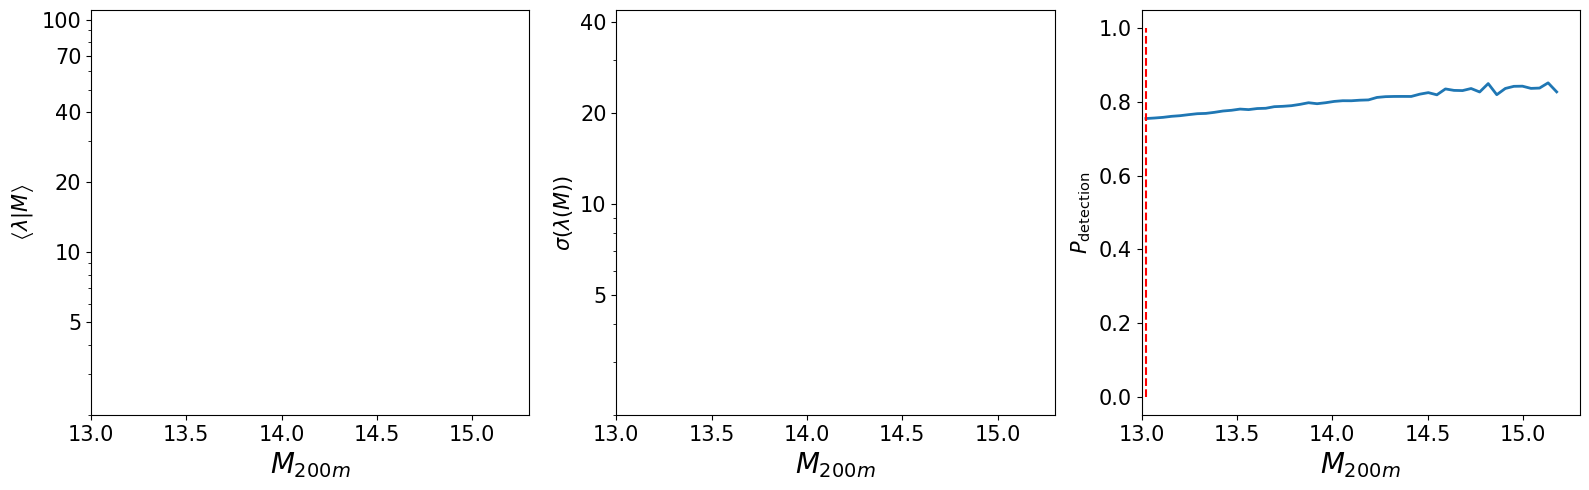

In [98]:
plt.figure( figsize = ( 16 , 5 ))
plt.subplot( 131 )
plt.plot( log10_m200_cents , mean_rich , lw = 2  )
plt.xlabel(r'$M_{200m}$' , fontsize = 20)
plt.ylabel(r'$\left< \lambda | M \right>$' , fontsize = 15)
plt.yscale('log')
plt.xlim( 13 , 15.3 )

plt.ylim( 2 , 110 )
plt.xticks( fontsize = 15 )
plt.yticks( ticks = [ 5 , 10 , 20 , 40 , 70 , 100  ],
            labels = [ 5 , 10 , 20 , 40 , 70 , 100  ] , fontsize = 15 )

plt.subplot( 132 )
plt.plot( log10_m200_cents , var_rich**0.5 , lw = 2  )
plt.xlabel(r'$M_{200m}$' , fontsize = 20)
plt.ylabel(r'$\sigma( \lambda( M ))$' , fontsize = 15)
plt.yscale('log')
plt.xticks( fontsize = 15 )
plt.yticks( ticks = [ 5 , 10 , 20 , 40 ],
            labels = [ 5 , 10 , 20 , 40 ] , fontsize = 15 )
plt.ylim(  2 , 44 )
plt.xlim( 13 , 15.3 )

plt.subplot( 133 )
plt.plot( log10_m200_cents , sel_counts / all_counts , lw = 2  )
plt.plot( [ val_50 , val_50 ] , [ 0 , 1 ] , 'r--' )
plt.xlabel(r'$M_{200m}$' , fontsize = 20)
plt.ylabel(r'$P_{\rm{detection}}$' , fontsize = 15)
plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.xlim( 13 , 15.3 )

plt.tight_layout()

In [99]:
#log10_m200_bins = np.linspace( 13.05 , 15.2 , 120 )
log10_m200_bins = np.arange( 13.05 , 16 , 0.05 )
log10_m200_cents = ( log10_m200_bins[1:] + log10_m200_bins[:-1] )/2.

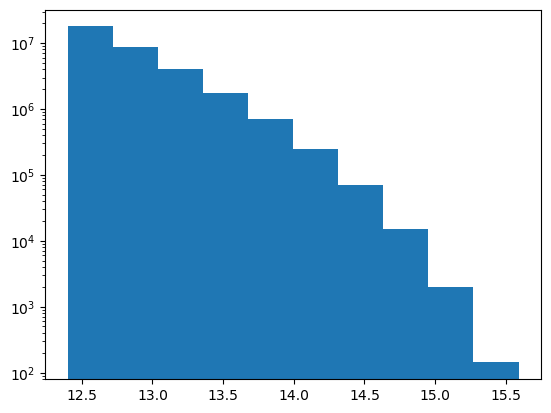

In [100]:
plt.hist( log10_m_true_all_no_z )
plt.yscale('log')

In [101]:
richness_filter_0 = ( sim_richness < 20 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_1 = ( sim_richness < 30 ) & ( sim_richness > 20 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_2 = ( sim_richness < 45 ) & ( sim_richness > 30 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_3 = ( sim_richness < 60 ) & ( sim_richness > 45 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 
richness_filter_4 = ( sim_richness < 250 ) & ( sim_richness > 60 ) & ( sim_z_clusters > 0.2 ) & ( sim_z_clusters < 0.857 ) 

labels_lambda = [r' $\lambda_{\rm{pmem}}$ < 20 ',
          r'20 <  $\lambda_{\rm{pmem}}$ < 30',
          r'30 <  $\lambda_{\rm{pmem}}$ < 45',
          r'45 <  $\lambda_{\rm{pmem}}$ < 60',
          r'60 <  $\lambda_{\rm{pmem}}$ < 250']


print( len( sim_richness[richness_filter_0] ))
print( len( sim_richness[richness_filter_1] ))
print( len( sim_richness[richness_filter_2] ))
print( len( sim_richness[richness_filter_3] ))
print( len( sim_richness[richness_filter_4] ))

log10m_bins = np.linspace( 13 , 16 , 30 )
log10m_cents = ( log10m_bins[1:] + log10m_bins[:-1] )/2.

count_pzwav_pure_80_mis_mf0 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_0] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf1 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_1] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf2 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_2] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf3 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_3] , bins = log10_m200_bins )
count_pzwav_pure_80_mis_mf4 , _ = np.histogram( log10_m_true_all_no_z[richness_filter_4] , bins = log10_m200_bins )

count_m = [ count_pzwav_pure_80_mis_mf0,
               count_pzwav_pure_80_mis_mf1,
               count_pzwav_pure_80_mis_mf2,
               count_pzwav_pure_80_mis_mf3,
               count_pzwav_pure_80_mis_mf4 ]


8372113
387267
396028
286653
1475336


/tmp/ipykernel_1197/3696345844.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


(13.0, 16.0)

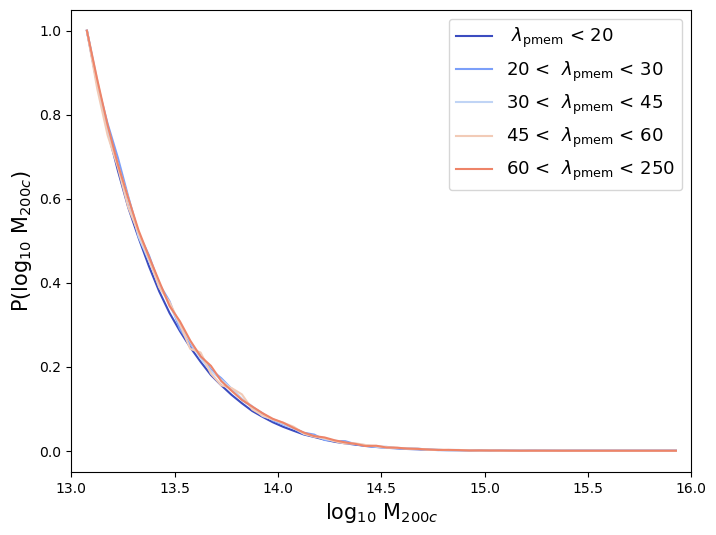

In [102]:
plt.figure( figsize = ( 8 , 6 ) )

# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

for i in range(len(count_m)):
    color = cmap(i / len(count_m))  # Get the color from the colormap
    plt.plot( log10_m200_cents , count_m[i] / np.max(count_m[i]), label=labels_lambda[i], color=color )
    plt.legend(fontsize=13)
    
plt.xlabel(r'log$_{10}$ M$_{200c}$' , fontsize = 15 )
plt.ylabel(r'P(log$_{10}$ M$_{200c})$' , fontsize = 15 )
plt.xlim( 13, 16 )

In [103]:
class CustomPrior(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define uniform priors for the parameters
        self.prior_uniform =  utils.BoxUniform( 
                          low = [ 0.05 , 0.5 , -3 , -2 , 0 , 1 , 0.05, -1  ] , 
                          high = [ 1.0 , 1.3 , -0.1 , 2 , 2 , 5 , 1 , 1 ] )
    
    def log_prob(self, x):
        # Check the constraint w0 + wa < 0
        w0_plus_wa = x[..., 2] + x[..., 3]  # assuming w0 is at index 2 and wa at index 3
        mask = ( w0_plus_wa < 0 )
        return torch.where( mask, self.prior_uniform.log_prob(x), torch.tensor(-float('inf')))
    
    def sample(self, sample_shape=torch.Size()):
        if len(sample_shape) == 0:
            sample_shape = torch.Size([1])  # Default to a single sample if sample_shape is empty
            
        samples = []
        while len(samples) < sample_shape[0]:
            sample = self.prior_uniform.sample((1,))
            if (sample[..., 2] + sample[..., 3]).lt(0):  # Ensure w0 + wa < 0
                samples.append(sample)
                
        return torch.cat(samples, dim=0)

# Instantiate the custom prior
w0_plus_wa_positive_prior = CustomPrior()

In [104]:
# make sure that this is the correct size
prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 0 , 1 , 0.05 ] , 
                          high = [ 1.0 , 1.5 , 2 , 5 , 0.5  ] )

In [105]:
#stacked_simulator.set_bins( z_bins = np.arange( 0.15 , 0.7 , 0.05 ) , log10m_bins=  np.arange( 13.1 , 15.5, 0.01) )

In [106]:
stacked_simulator.dOmega

0.45692570047120834

In [108]:
# infer posteriors
des_posterior = infer( stacked_simulator.run_simulation , 
                       prior, 
                       method = "SNPE", 
                       num_simulations = 1000 , 
                       num_workers = 120 )

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )
/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )
/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )
/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )
/pbs/home/c/cmurray/cluster_likelihood/modules/simulation.py:294: RuntimeWarning: divide by zero encountered in log
  ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l ) ) )
/pbs/ho

KeyboardInterrupt: 

In [ ]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/des_posterior.pkl', "wb") as handle:
    pickle.dump( des_posterior, handle)

In [130]:
# make sure that this is the correct size
prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 0 , 1 , 0.05 ] , 
                          high = [ 1.0 , 1.5 , 2 , 5 , 0.5  ] )

In [131]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/des_posterior_power_law_lambda_30.pkl', 'rb') as file:
    des_posterior = pickle.load(file)

In [132]:
# # infer posteriors
# old_des_posterior = infer( old_stacked_simulator.run_simulation , 
#                        prior, 
#                        method = "SNPE", 
#                        num_simulations = 10000 , 
#                        num_workers = 40 )

In [133]:
# no_r_prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 0 , 1 , 0.05 ] , 
#                           high = [ 1.0 , 1.5 , 2 , 5 , 1 ] )

In [134]:
# no_r_des_posterior = infer( no_r_stacked_simulator.run_simulation , 
#                            no_r_prior, 
#                            method = "SNPE", 
#                            num_simulations = 60000 , 
#                            num_workers = 40 )

In [135]:
# with open('/sps/euclid/Users/cmurray/clusters_likelihood/no_r_des_posterior.pkl', "wb") as handle:
#     pickle.dump( no_r_des_posterior, handle)

In [136]:
# with open('/sps/euclid/Users/cmurray/clusters_likelihood/no_r_des_posterior.pkl', 'rb') as file:
#     no_r_des_posterior = pickle.load(file)

In [5]:


# des_lambda_bins = np.array( [ 20 , 30 , 45 , 60 , 240 ])
des_lambda_bins = np.array( [ 30 , 45 , 60 , 240 ])
des_z_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])

i = 0 
z_idx_0 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 1 
z_idx_1 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 2 
z_idx_2 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )

n_clusters_0 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_0 ], bins = des_lambda_bins )
n_clusters_1 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_1 ], bins = des_lambda_bins )
n_clusters_2 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_2 ], bins = des_lambda_bins )


mwl_mean_0 = np.array( [ 14.323 , 14.454 , 14.758 ] )
mwl_mean_1 = np.array( [ 14.291 , 14.488 , 14.744 ] )
mwl_mean_2 = np.array( [ 14.301 , 14.493 , 14.724 ] )


mwl_std_0 = np.array( [ 0.031 + 0.051 , 0.044 + 0.050 , 0.038 + 0.052 ] )
mwl_std_1 = np.array( [ 0.031 + 0.061 , 0.044 + 0.065 , 0.038 + 0.052 ] )
mwl_std_2 = np.array( [ 0.041 + 0.086 , 0.056 + 0.068 , 0.061 + 0.069 ] )

In [28]:


des_lambda_bins = np.array( [ 20 , 30 , 45 , 60 , 240 ])
des_z_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])

i = 0 
z_idx_0 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 1 
z_idx_1 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )
i = 2 
z_idx_2 = ( redmapper_catalogue['Z_LAMBDA'] < des_z_bins[i+1] ) & ( redmapper_catalogue['Z_LAMBDA'] > des_z_bins[i] )

n_clusters_0 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_0 ], bins = des_lambda_bins )
n_clusters_1 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_1 ], bins = des_lambda_bins )
n_clusters_2 , _  = np.histogram( redmapper_catalogue['LAMBDA'][ z_idx_2 ], bins = des_lambda_bins )

# Mean mass results, Table II DES Y1 cluster abundance results
mwl_mean_0 = np.array( [ 14.036 , 14.323 , 14.454 , 14.758 ] )
mwl_mean_1 = np.array( [ 14.007 , 14.291 , 14.488 , 14.744 ] )
mwl_mean_2 = np.array( [ 13.929 , 14.301 , 14.493 , 14.724 ] )

# Std for aMean mass results, Table II DES Y1 cluster abundance results
mwl_std_0 = np.array( [ 0.032 + 0.045 , 0.031 + 0.051 , 0.044 + 0.050 , 0.038 + 0.052 ] )
mwl_std_1 = np.array( [ 0.033 + 0.056 , 0.031 + 0.061 , 0.044 + 0.065 , 0.038 + 0.052 ] )
mwl_std_2 = np.array( [ 0.048 + 0.072 , 0.041 + 0.086 , 0.056 + 0.068 , 0.061 + 0.069 ] )


In [29]:
# Assuming the arrays are already of the same shape and are 2D
n_clusters = np.array( [ n_clusters_0, n_clusters_1, n_clusters_2 ]).T
mwl_mean = np.array( [ mwl_mean_0, mwl_mean_1, mwl_mean_2 ] ).T

# Flatten both stacks and concatenate them to match the format of the `stacked_counts` result
des_stacked_results = np.vstack( np.array( [ n_clusters, mwl_mean ] ) ).flatten()  

In [30]:
nsamples = 100000
samples_des_y1 = des_posterior.sample( (nsamples,), x = des_stacked_results )

NameError: name 'des_posterior' is not defined

In [142]:
# nsamples = 100000
# old_samples_des_y1 = old_des_posterior.sample( (nsamples,), x = des_stacked_results )

In [118]:
# nsamples = 1000000
# no_r_samples_des_y1 = no_r_des_posterior.sample( (nsamples,), x = des_stacked_results )

In [143]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}'  ]# , r'\rho' ]#, r'c_{\rho}']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [119]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}'  ]# , r'\rho' ]#, r'c_{\rho}']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [120]:
np.random.poisson( lam = [ 5 , 10 , 15 ])

array([10, 10, 19])

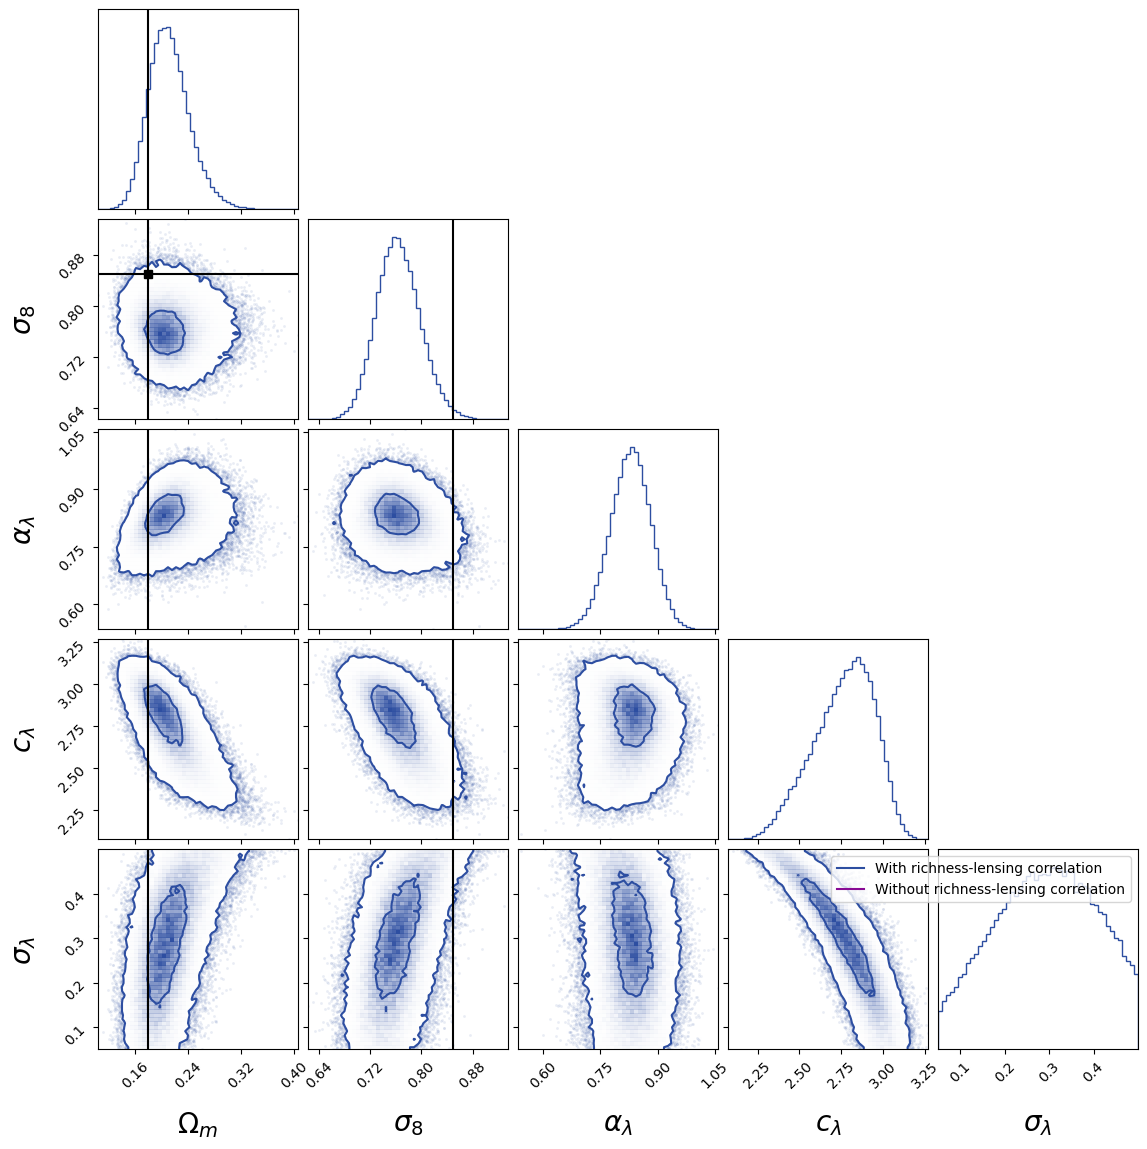

In [121]:
#limits = [ ( 0 , 1 ), (  , 60 ) , ( 0 , 200  ) ,( -0.01 , -0.002 )]
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']

labels = ['$\Omega_m$' , '$\sigma_8$' ,r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' ]# , r'$\rho$'] #, r'$c_{\rho}$']
truths = [ 0.18 , 0.85 , None , None , None ]#, None ]

# labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]


figure = corner.corner( samples_des_y1.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

# corner.corner( alt_samples_des_y1.numpy() , fig = figure , 
#                        levels = [ 0.393 , 0.98 ] ,  
#                        bins = 50 , 
#                        hist_kwargs={'density': True},
#                        #range = limits,
#                        labels = labels,
#                        color ='#880a94',
#                        truths = truths,
#                        truth_color = 'k',
#                        label_kwargs={"fontsize": 20},
#                        title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend( loc="upper right" )
# plt.savefig('both_bins.pdf')


print()

In [122]:
# make sure that this is the correct size
prior = utils.BoxUniform( low = [ 0.05 , 0.5 , 0.4 , np.log10( 10. ) , 10. , 0.05 ] , 
                          high = [ 1.0 , 1.5 , 2, np.log10( 30. ) , 14. , 0.5  ] )

In [44]:
from torch.distributions import Distribution, Uniform, Normal

In [70]:
# Define individual priors with correct tensor shape
prior_om = Uniform(torch.tensor([0.05]), torch.tensor([1.0]))
prior_s8 = Uniform(torch.tensor([0.5]), torch.tensor([1.5]))
prior_h = Normal(torch.tensor([0.7]), torch.tensor([0.1]))  # Normal prior on h
prior_alpha = Uniform(torch.tensor([0.4]), torch.tensor([1.2]))
prior_B = Uniform(torch.tensor([np.log10(10)]), torch.tensor([np.log10(30)]))
prior_log10Mmin = Uniform(torch.tensor([10.0]), torch.tensor([14.0]))
prior_beta = Uniform(torch.tensor([-5.0]), torch.tensor([5.0]))
prior_sigma = Uniform(torch.tensor([0.05]), torch.tensor([0.5]))

# Combine the priors into a list for processing
priors = [prior_om, prior_s8, prior_h, prior_alpha, prior_B, prior_log10Mmin, prior_beta, prior_sigma]

In [77]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/des_posterior_halo_model.pkl', 'rb') as file:
    des_posterior = pickle.load(file)
    
with open('/sps/euclid/Users/cmurray/clusters_likelihood/des_posterior_halo_model_redshift_evolution_with_h_normal_prior.pkl', 'rb') as file:
    des_posterior = pickle.load(file)

In [78]:
nsamples = 100000
samples_des_y1 = des_posterior.sample( (nsamples,), x = des_stacked_results )

Drawing 100000 posterior samples: 100100it [00:17, 5736.22it/s]                           


In [79]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'b', 'log10Mmin' , '\sigma_{\lambda}'  ]# , r'\rho' ]#, r'c_{\rho}']
labels_math = ['\Omega_m' , '\sigma_8'  , 'h' , r'\alpha_{\lambda}' , 'b', 'log10Mmin' , r'\beta' , '\sigma_{\lambda}' ]# , r'\rho' ]#, r'c_{\rho}']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:
np.log10( 10**11.432 * 10**1.22 )

12.652000000000001

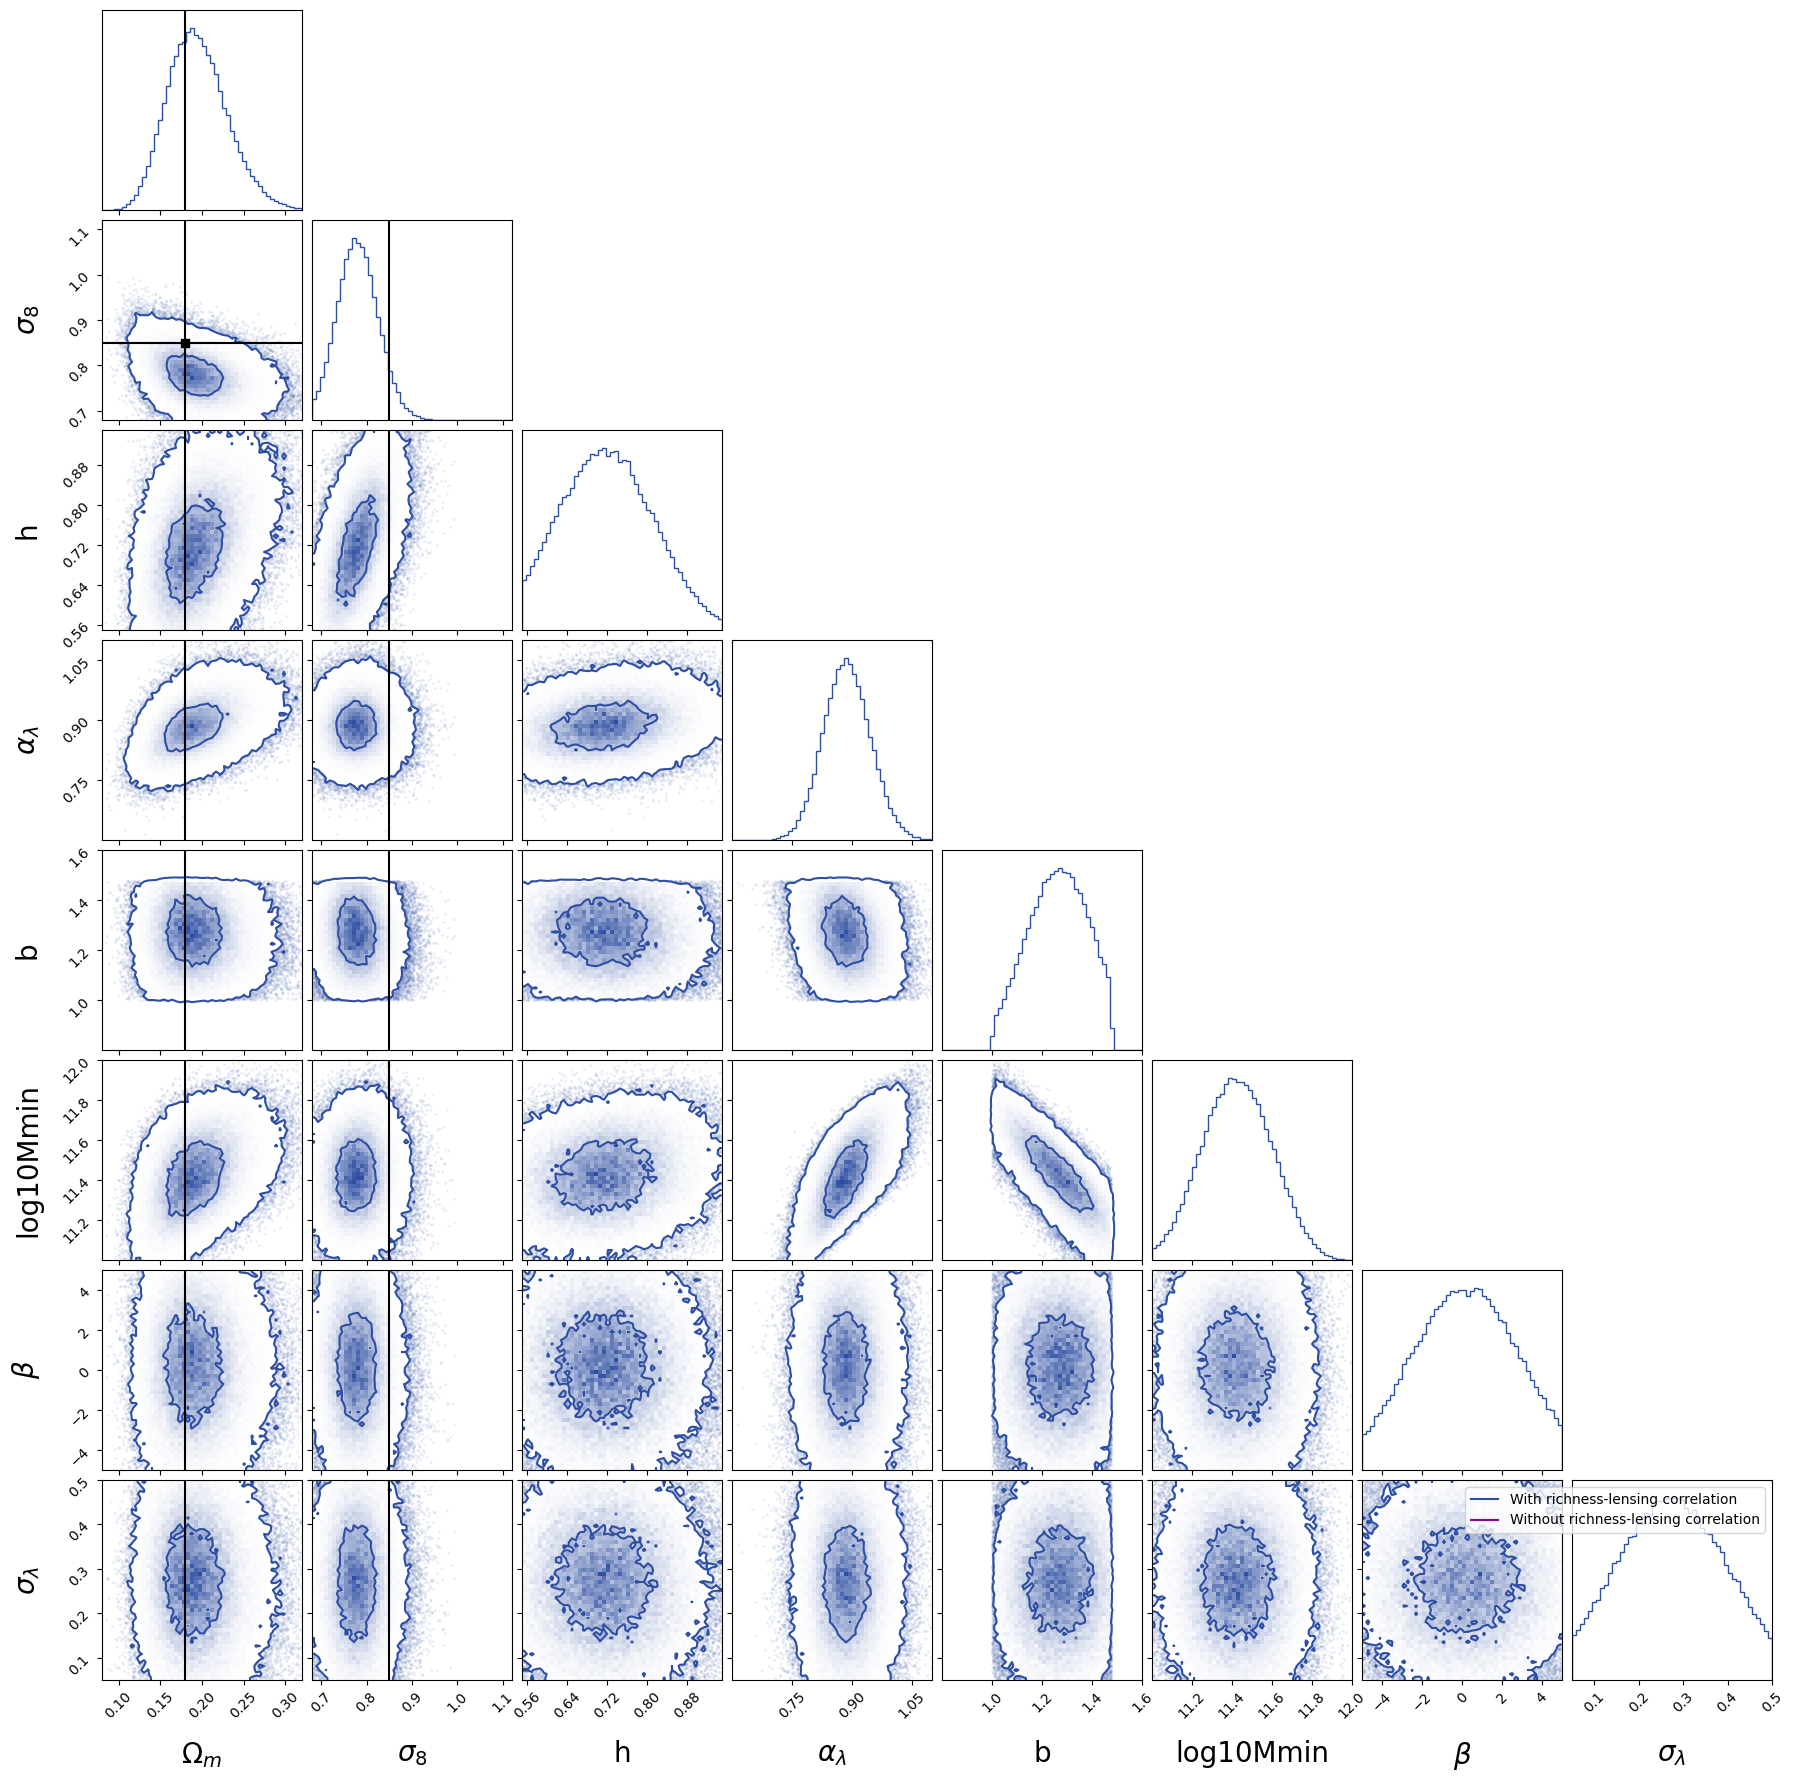

In [81]:
limits = [ ( 0.08 , 0.32 ) , ( 0.68 , 1.12 ), ( 0.55 , 0.95 ) , ( 0.6 , 1.1  ) ,( 0.8 , 1.6 ) , ( 11 , 12 ) , ( -5 , 5 ) , ( 0.05 , 0.5 )]
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']

labels = ['$\Omega_m$' , '$\sigma_8$'  , r'$\alpha_{\lambda}$' , 'b', 'log10Mmin' , '$\sigma_{\lambda}$' ]# , r'$\rho$'] #, r'$c_{\rho}$']
labels = ['$\Omega_m$' , '$\sigma_8$' , 'h' , r'$\alpha_{\lambda}$' , 'b', 'log10Mmin' , r'$\beta$' , '$\sigma_{\lambda}$' ]# , r'$\rho$'] #, r'$c_{\rho}$']
truths = [ 0.18 , 0.85 , None , None , None , None , None , None ]

# labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]


figure = corner.corner( samples_des_y1.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

# corner.corner( alt_samples_des_y1.numpy() , fig = figure , 
#                        levels = [ 0.393 , 0.98 ] ,  
#                        bins = 50 , 
#                        hist_kwargs={'density': True},
#                        #range = limits,
#                        labels = labels,
#                        color ='#880a94',
#                        truths = truths,
#                        truth_color = 'k',
#                        label_kwargs={"fontsize": 20},
#                        title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend( loc="upper right" )
plt.savefig('both_bins.pdf')


print()

In [258]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' ]# , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( no_r_samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [136]:
# samples_des_y1 = des_posterior.sample( (nsamples,), x = sim_obs )

\begin{equation}
\left< M_l | \lambda , z \right> \frac{1}{N} \int dz d\lambda P( \lambda | m , z ) M
\end{equation}

mais ce masse moyenne vient de stacked shear, alors 

\begin{equation}
\left< \Delta \Sigma | {M_i} \right> \rightarrow \left< M \right>
\end{equation}

par contre

\begin{equation}
\Delta \Sigma(M) \propto r_{vir} \propto M^{1/3}
\end{equation}

donc le masse moyenne que on 'infer' de stacked weak lensing sera plutot,

\begin{equation}
\left< M_l | \lambda , z \right> \frac{1}{N} \int dz d\lambda P( \lambda | m , z ) M^{1/3}
\end{equation}

In [57]:
samples_des_y1.numpy().shape

(100000, 6)

In [145]:
alt_samples_des_y1.numpy().shape

(1000000, 5)

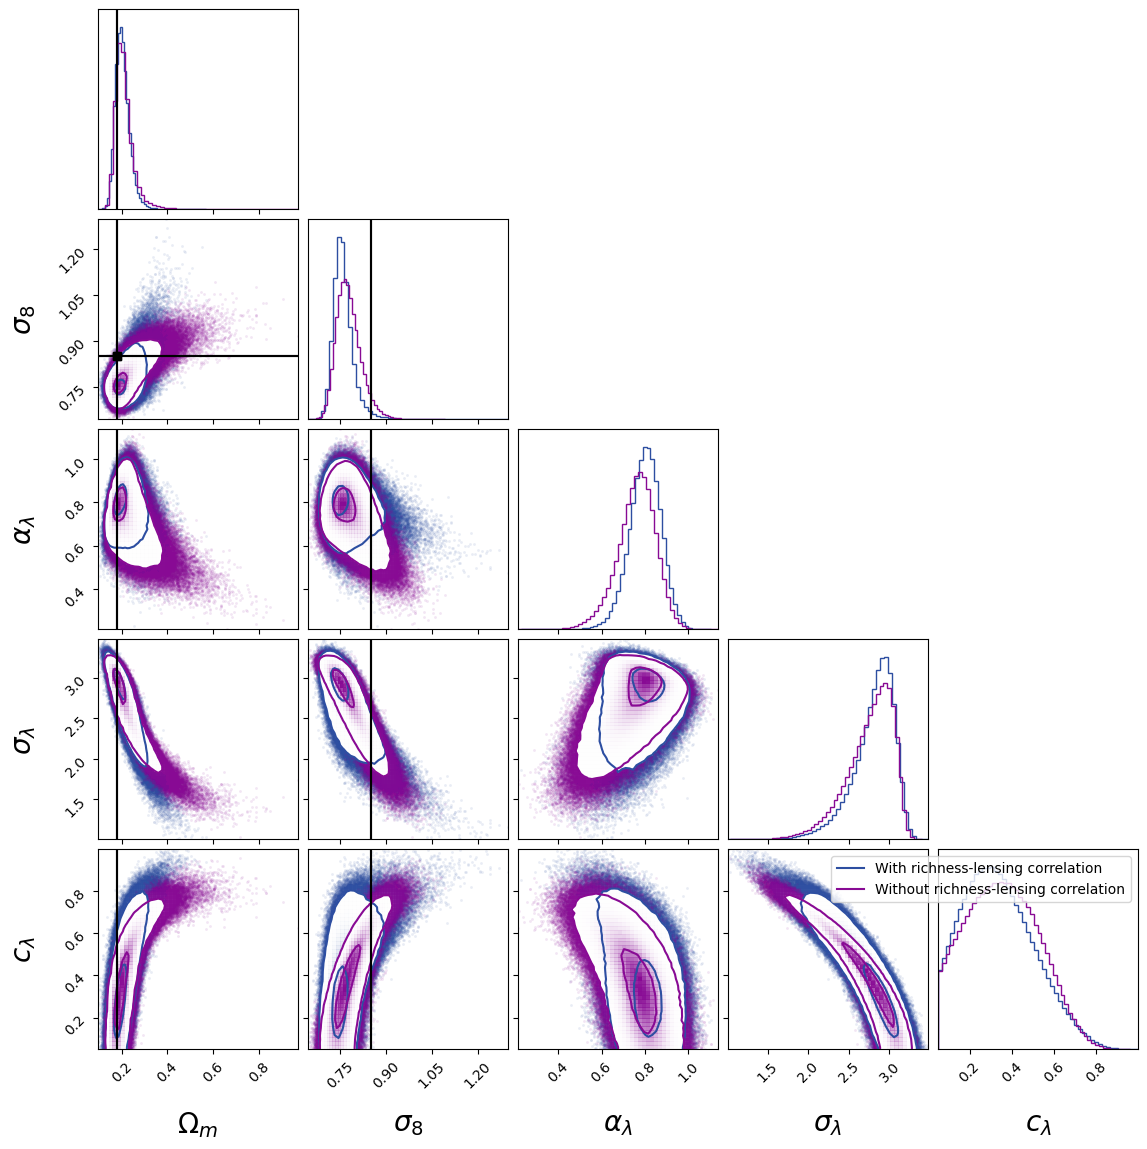

In [148]:
# Updated labels and limits for 5D plot (since alt_samples has 5 dimensions)
labels_5d = ['$\Omega_m$', '$\sigma_8$', r'$\alpha_{\lambda}$', r'$\sigma_{\lambda}$', r'$c_{\lambda}$' ]#, 'r']
truths_5d = [0.18, 0.85, None, None, None ]

# Slice the 6D samples to 5D to match alt_samples
samples_sliced = samples_des_y1.numpy()[:, :5]  # Selecting the first 5 dimensions

# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_sliced, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels_5d,
                       color='#2d4ea1',
                       truths=truths_5d,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Add the alt_samples to the same corner plot
corner.corner(alt_samples_des_y1.numpy(), fig=figure, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels_5d,
                       color='#880a94',
                       truths=truths_5d,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend(loc="upper right")

# Save the plot
plt.savefig('both_bins.pdf')
plt.show()


In [77]:
samples_des_y1.shape

torch.Size([100000, 7])

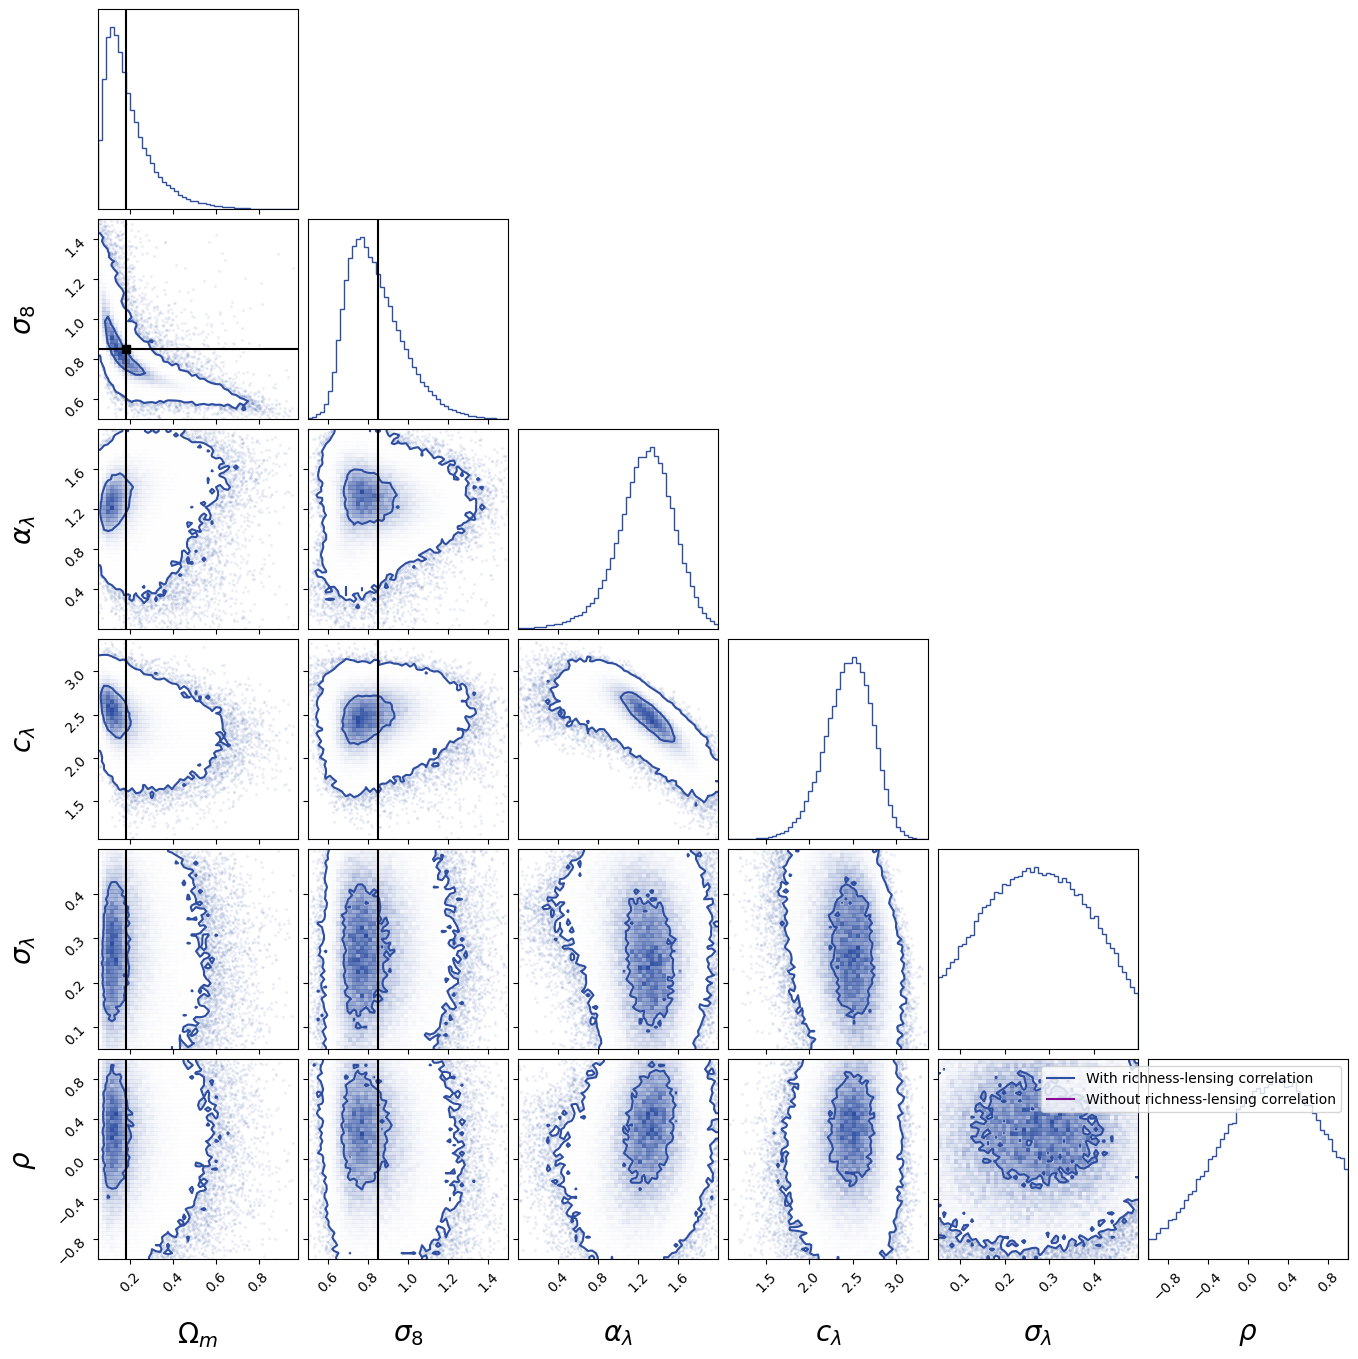

In [74]:
limits = [ ( 180 , 360 ), ( -20 , 60 ) , ( 0 , 200  ) ,( -0.01 , -0.002 )]
labels = ['$\Omega_m$' , '$\sigma_8$' , r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']

labels = ['$\Omega_m$' , '$\sigma_8$' ,r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' , r'$\rho$'] #, r'$c_{\rho}$']
truths = [ 0.18 , 0.85 , None , None , None , None ]

# labels = ['$\Omega_m$' , '$\sigma_8$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , 0.8 , 0.3 , 3  ]


figure = corner.corner( samples_des_y1.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )

# corner.corner( alt_samples_des_y1.numpy() , fig = figure , 
#                        levels = [ 0.393 , 0.98 ] ,  
#                        bins = 50 , 
#                        hist_kwargs={'density': True},
#                        #range = limits,
#                        labels = labels,
#                        color ='#880a94',
#                        truths = truths,
#                        truth_color = 'k',
#                        label_kwargs={"fontsize": 20},
#                        title_kwargs={"fontsize": 25}  )

plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend( loc="upper right" )
# plt.savefig('both_bins.pdf')


print()

IndexError: list index out of range

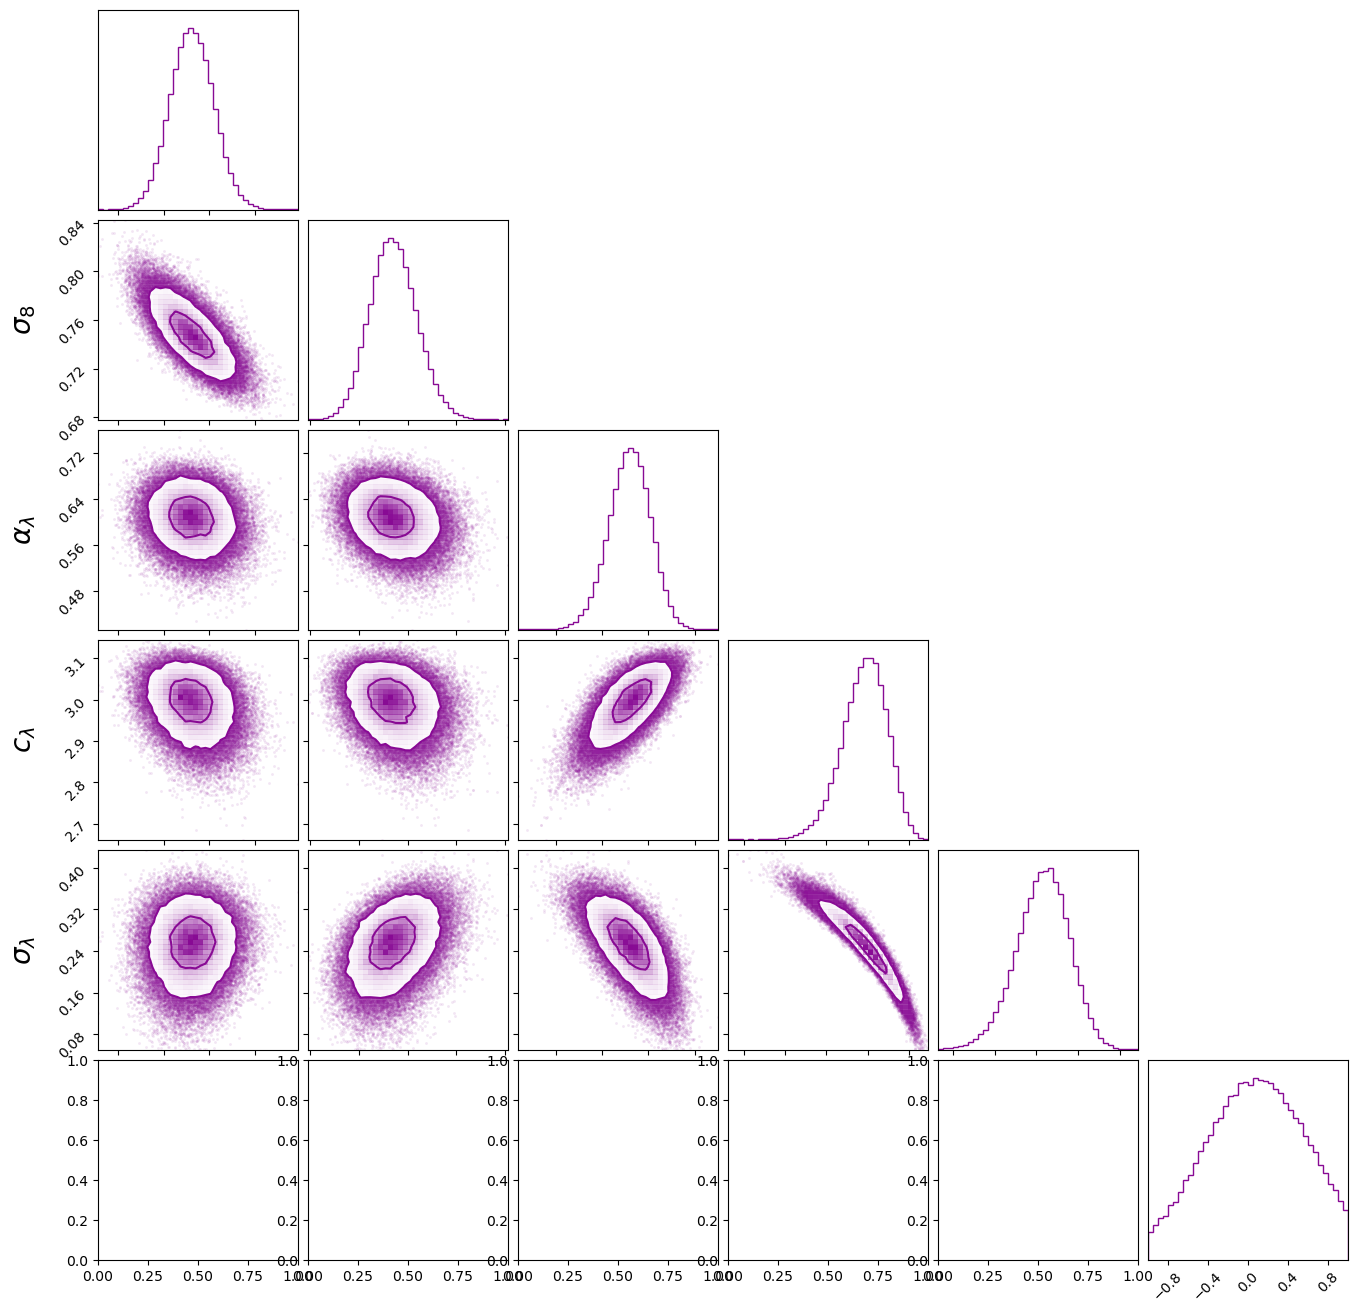

In [109]:
# labels = ['$\Omega_m$' , '$\sigma_8$' , '$w_0$', '$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' ,r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' ]
truths = [ 0.18 , 0.85 , None , None , None , None  ]

#truths = [ 264 , 48 , 369 , np.nan]
figure = corner.corner( alt_samples_des_y1.numpy() , 
                       levels = [ 0.393, 0.865 ] ,  
                       bins = 40 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})
plt.savefig('desy1.pdf')
print()

In [150]:
a

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [151]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [152]:
1/0.8

1.25

In [ ]:
median_params

In [ ]:
mean_params

In [50]:
stacked_simulator_w0wa = simulation.Universe_simulation( 'stacked_counts' ,
                                                    variable_params=['omega_m', 'sigma_8' ,'w_0' , 'w_a', 'alpha' , 'c' , 'sigma' , 'r' ] )

stacked_simulator_w0wa.dOmega = 1500/41253 * 4*np.pi
stacked_simulator_w0wa.richness_bins = des_lambda_bins
stacked_simulator_w0wa.redshift_bins = des_z_bins
stacked_simulator_w0wa.z_bins = np.arange( 0.15 , 0.7 , 0.05 )
stacked_simulator_w0wa.sigma_mwl = 0.3
stacked_simulator_w0wa.log10ms = np.arange(13.1, 15.5, stacked_simulator_w0wa.dlog10m)

In [ ]:
# infer posteriors
des_posterior_w0wa = infer( stacked_simulator_w0wa.run_simulation , 
                           w0_plus_wa_positive_prior, 
                           method = "SNPE", 
                           num_simulations = 20000 , 
                           num_workers = 40 )

/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/sbi/utils/user_input_checks_utils.py:392: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
Running 20000 simulations in 20000 batches.:  63%|██████▎   | 12609/20000 [1:13:26<56:41,  2.17it/s]  

In [78]:
nsamples = 100000
samples_des_y1_w0wa = des_posterior_w0wa.sample( (nsamples,), x = des_stacked_results )

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:01<00:00, 85941.74it/s]


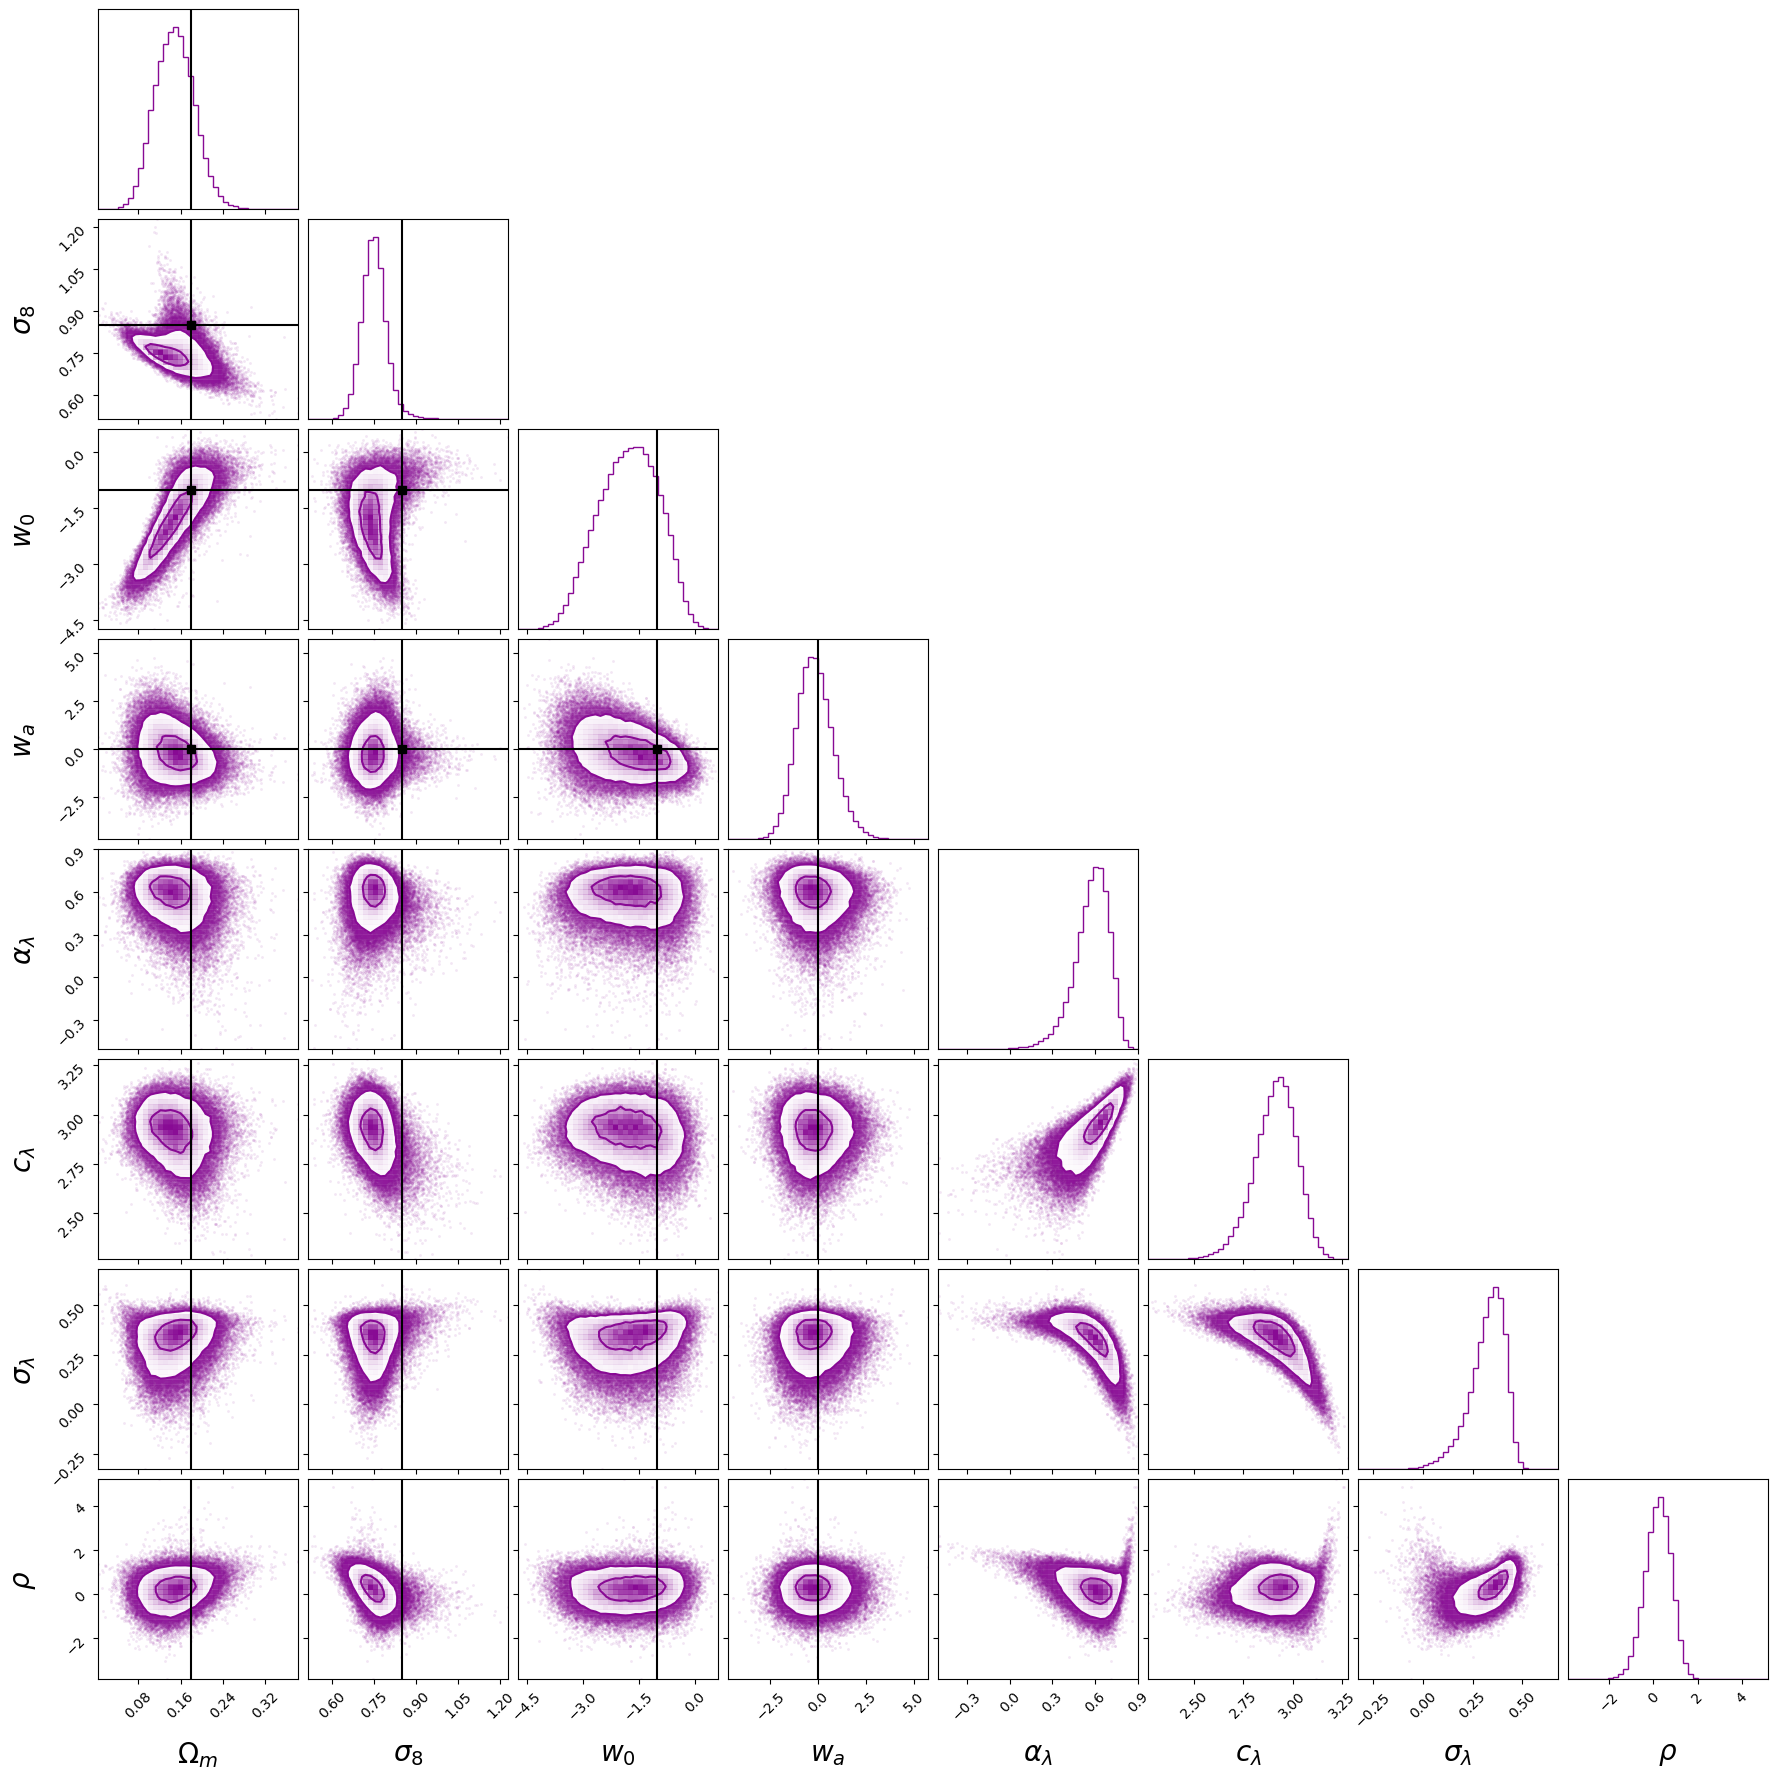

In [79]:
# labels = ['$\Omega_m$' , '$\sigma_8$' , '$w_0$', '$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
# truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$', r'$\alpha_{\lambda}$' , r'$\sigma_{\lambda}$' , r'$c_{\lambda}$']
truths = [ 0.3 , 0.8 , -1 , 0 , 0.8 , 0.3 , 3  ]

labels = ['$\Omega_m$' , '$\sigma_8$' , r'$w_0$' , r'$w_a$',r'$\alpha_{\lambda}$' , r'$c_{\lambda}$' ,  r'$\sigma_{\lambda}$' , r'$\rho$',]
truths = [ 0.18 , 0.85 , -1 , 0 , None , None , None , None  ]

#truths = [ 264 , 48 , 369 , np.nan]
figure = corner.corner( samples_des_y1_w0wa.numpy() , 
                       levels = [ 0.393, 0.865 ] ,  
                       bins = 40 , 
                       hist_kwargs={'density': True},
                       #range = limits,
                       labels = labels,
                       color ='#880a94',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})
plt.savefig('desy1.pdf')
print()

In [81]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_des_y1_w0wa.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [83]:
1/0.7

1.4285714285714286

In [ ]:
# same S8 as the fiducial DES analysis
S8 = 1 * ( 0.449 / 0.3 )**0.5
S8

In [54]:
# same S8 as the fiducial DES analysis
S8 = 0.6 * ( 0.359 / 0.3 )**0.5
S8

0.6563535632568775

In [55]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.2 , 0.75 , -1 , 0 , 0.8 , 0.1 , 3 ] )  )

In [ ]:
sim_n_clusters = sim_obs[:12].reshape( 4 , 3 )
sim_mwl_mean = sim_obs[12:].reshape( 4 , 3 )

sim_n_clusters_0 = sim_n_clusters.T[0]
sim_n_clusters_1 = sim_n_clusters.T[1]
sim_n_clusters_2 = sim_n_clusters.T[2]

sim_mwl_mean_0 = sim_mwl_mean.T[0]
sim_mwl_mean_1 = sim_mwl_mean.T[1]
sim_mwl_mean_2 = sim_mwl_mean.T[2]

In [ ]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( des_lambda_cent , n_clusters_0 , 'b-' )
plt.plot( des_lambda_cent , n_clusters_1 , 'c-' )
plt.plot( des_lambda_cent , n_clusters_2 , 'g-' )

plt.plot( des_lambda_cent , sim_n_clusters_0 , 'b--' )
plt.plot( des_lambda_cent , sim_n_clusters_1 , 'c--' )
plt.plot( des_lambda_cent , sim_n_clusters_2 , 'g--' )
plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 50 , 6000 )

plt.subplot(122)
plt.plot( des_lambda_cent , mwl_mean_0 , 'b-' )
plt.plot( des_lambda_cent , mwl_mean_1 , 'c-' )
plt.plot( des_lambda_cent , mwl_mean_2 , 'g-' )

plt.plot( des_lambda_cent , sim_mwl_mean_0 , 'b--' )
plt.plot( des_lambda_cent , sim_mwl_mean_1 , 'c--' )
plt.plot( des_lambda_cent , sim_mwl_mean_2 , 'g--' )
plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )